In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import MaxNLocator
import pickle
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate

fig_size_single = 3.37
fig_size_double = 6.69

#%% defining style
plt.rcParams.update({'font.size': 8})
plt.rcParams['font.sans-serif']= 'Arial'
plt.rcParams["figure.figsize"] = (fig_size_single, 3)  #it should be 3 
plt.rcParams['figure.dpi'] = 150
plt.rcParams['mathtext.rm'] = 'Arial'
plt.rcParams['mathtext.default'] = 'it' #'regular'

plt.rcParams['legend.frameon']= False
plt.rcParams['legend.fontsize']= 'small'
plt.rcParams['legend.scatterpoints']= 1
plt.rcParams['axes.labelpad'] = 4 #-2

In [3]:
fq1=1.514  #resonance frequencies at (-10,10) mV point
fq1b=1.570
fq2=2.655
fq2b=2.714

# 1. Fitting the spectrums

## fQ1 spectrum

In [4]:
def merge_lists(x1, x2, y1, y2):  #to not count twice the resonance points, which are both horizontal and vertical maximums
    # combine x1 and x2 and y1 and y2 into two separate lists
    x = x1 + x2
    y = y1 + y2

    # create a dictionary to keep track of unique pairs
    unique_pairs = {}

    # iterate through both lists simultaneously
    for i in range(len(x)):
        # get the current pair of x and y values
        pair = (x[i], y[i])

        # check if the pair already exists in the dictionary
        if pair in unique_pairs:
            # if it does, skip it (we only want unique pairs)
            continue
        else:
            # if it doesn't, add it to the dictionary
            unique_pairs[pair] = True

    # convert the dictionary keys back into separate lists
    x = [pair[0] for pair in unique_pairs.keys()]
    y = [pair[1] for pair in unique_pairs.keys()]

    return x, y

[ 0.17439208 -0.00104254 -0.01145871  0.03582596]
[3.32897645e-04 1.97520448e-05 1.04054302e-03 1.55299989e-04]


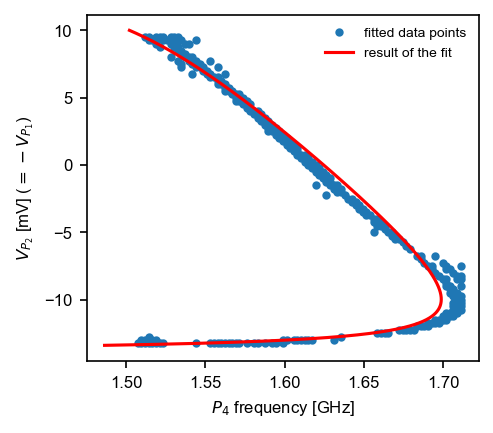

In [5]:
data_fq1=loadtxt('vPdetuning_set_frequency_set.dat')  #load in the data of fq1 resonance frequency 
fp4=data_fq1[:,1]*10**(-9)
VP2=data_fq1[:,0]
p=data_fq1[:,2]

muB=57.883818060*0.241799050402293  #Bohr-magneton in GHz 
B=0.675                             #magnetic field in Tesla 

p_max=max(p)      #this is the point with the highest probability 
fp4_fit=[]
VP2_fit=[]
p_fit=[]

for i in range(len(p)):        #This is where we search for the resonant points
    if p[i]>0.48*p_max:        #because the resonance is quite sharp, it is enough to look for points with high probability
        if fp4[i]<1.712:
            if VP2[i]<9.7 and VP2[i]>-13.5:
                if not(fp4[i]>1.56 and VP2[i]>8):     #here we drop the noise
                    if not(fp4[i]<1.51 and VP2[i]>8):
                        fp4_fit.append(fp4[i])        #store the points
                        VP2_fit.append(VP2[i])
                        p_fit.append(p[i])
fp4_fit=array(fp4_fit)
VP2_fit=array(VP2_fit)
p_fit=array(p_fit)

def fq1_fit(VP2,g10,c1,d,a):   #theoretical function for fQ1 
    return muB*B*(g10+c1*VP2)+2*d*1/(1-4*a**2*VP2**2)

popt,pcov=curve_fit(fq1_fit,VP2_fit,fp4_fit,p0=[0.18,-0.0017,-0.05,0.032],maxfev=100000) #we fit the data points 
perr=sqrt(diag(pcov))
print(popt)
print(perr)

gamma=popt[2]
dgamma=perr[2]
g10=popt[0]
c1=popt[1]
d=popt[2]
aU=popt[3]*10**(-3)
a=popt[3]

plot(fp4_fit,VP2_fit,linestyle='',marker='.',label='fitted data points')   #plot the found resonance points 

x=linspace(-13.4,10,5000)
plot(fq1_fit(x,popt[0],popt[1],popt[2],1.00*popt[3]),x,color='red',label='result of the fit')  #plot the result 
#plot(fq1(x,0.18,-0.0017,-0.05,0.032),x,label='random')

xlabel(r'$P_4$ frequency [GHz]')
ylabel(r'$V_{P_2}$ [mV] ($=-V_{P_1}$)')
legend()

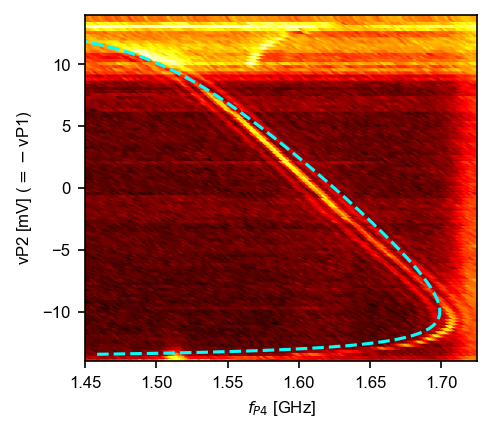

In [6]:
fig, ax = plt.subplots()

fp4_r = np.reshape(fp4,(113, 121))
VP2_r = np.reshape(VP2,(113, 121))
p_r = np.reshape(p,(113, 121))

rbf = scipy.interpolate.Rbf(fp4_r, VP2_r, p_r, function='linear')

zi = rbf(fp4_r, VP2_r)


plt.imshow(zi, vmin=p_r.min(), vmax=p_r.max(), origin='lower',aspect='auto',
           extent=[fp4_r.min(), fp4_r.max(), VP2_r.min(), VP2_r.max()])

plt.scatter(fp4_r, VP2_r, c=p_r,cmap='hot')  #plot the colormap, to see the result of the fitting 
x=linspace(-13.45,12.5,5000)
xlim(min(fp4),max(fp4))
ylim(min(VP2),max(VP2))
plot(fq1_fit(x,popt[0],popt[1],popt[2],popt[3]),x,linestyle='dashed',color='cyan')  #plot the result of the fit 

xlabel(r'$f_{P4}$ [GHz]')
ylabel(r'vP2 [mV] ($=-$vP1)')
fig.savefig('fq1-VP2.png', format='png', dpi=500,bbox_inches="tight")
fig.savefig('fq1-VP2.pdf', format='pdf', dpi=500,bbox_inches="tight")

## fQ2 spectrum

The spectrum of the $f_{Q2}$ will be fitted similarly to the spectrum of $f_{Q1}$, but two parameters are the same in the two theoretical formulas, so those two parameters, which we already know from the fit of $f_{Q1}$ here will be input parameters. 

[ 0.27062489 -0.00142594]
[1.45749946e-04 1.63320230e-05]


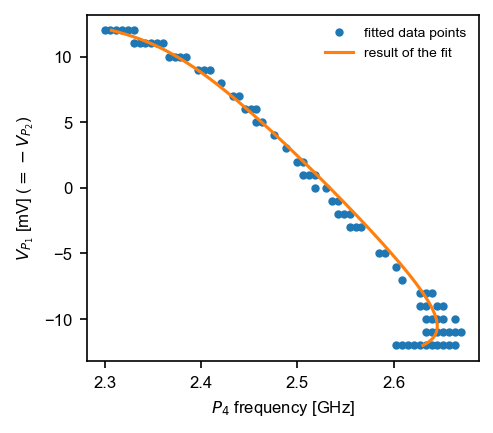

In [7]:
data_fq2=loadtxt('vPB12_set_frequency_set.dat')  #load the data for the detuning dependence of the fq2 
fp4_fq2=data_fq2[:,1]*10**(-9)
VP1_fq2=data_fq2[:,0]
p_fq2=data_fq2[:,2]

def fq2_fit(VP1,g20,c2): #theoretical curve for the detuning dependence of fq2
    #d=-0.01145871
    #a=0.03582596
    return muB*B*(g20+c2*VP1)+2*d*1/(1-4*a**2*VP1**2)

fig, ax = plt.subplots()

fp4_fq2_r = np.reshape(fp4_fq2,(25, 100))
VP1_fq2_r = np.reshape(VP1_fq2,(25, 100))
p_fq2_r = np.reshape(p_fq2,(25, 100))

p_fq2_max=max(p_fq2)     #the point with the highest probability 
fp4_fq2_fit=[]
VP1_fq2_fit=[]
p_fq2_fit=[]

for i in range(len(p_fq2)):
    if p_fq2[i]>0.5*p_fq2_max:         #the resonance is sharp, so we can look for points with high enough probability
        if not(fp4_fq2[i]>2.5 and VP1_fq2[i]>10):  #we drop the noise 
            fp4_fq2_fit.append(fp4_fq2[i])
            VP1_fq2_fit.append(VP1_fq2[i])
            p_fq2_fit.append(p_fq2[i])
fp4_fq2_fit=array(fp4_fq2_fit)
VP1_fq2_fit=array(VP1_fq2_fit)
p_fq2_fit=array(p_fq2_fit)

popt,pcov=curve_fit(fq2_fit,VP1_fq2_fit,fp4_fq2_fit,p0=[0.25,-0.0017],maxfev=50000)   #fitting of the data points 
perr=sqrt(diag(pcov))
print(popt)
print(perr)

g20=popt[0]
c2=popt[1]

x=linspace(min(VP1_fq2),max(VP1_fq2),5000)
plot(fp4_fq2_fit,VP1_fq2_fit,linestyle='',marker='.',label='fitted data points')  #plot the found data points 
plot(fq2_fit(x,popt[0],popt[1]),x,label='result of the fit')                      #plot the result of the fit 
xlabel(r'$P_4$ frequency [GHz]')
ylabel(r'$V_{P_1}$ [mV] ($=-V_{P_2}$)')

legend()

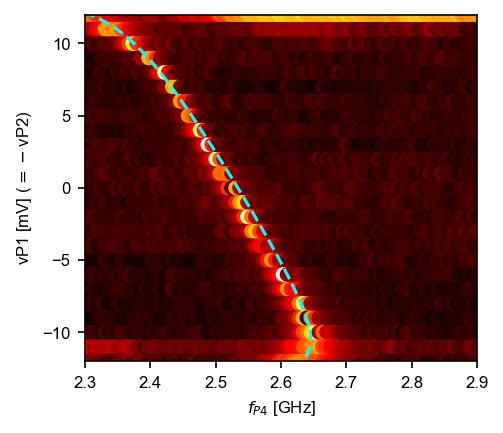

In [8]:
fig, ax = plt.subplots()

fp4_fq2_r = np.reshape(fp4_fq2,(25, 100))
VP1_fq2_r = np.reshape(VP1_fq2,(25, 100))
p_fq2_r = np.reshape(p_fq2,(25, 100))

rbf = scipy.interpolate.Rbf(fp4_fq2_r, VP1_fq2_r, p_fq2_r, function='linear')

zi = rbf(fp4_fq2_r, VP1_fq2_r)

plt.imshow(zi, vmin=p_fq2_r.min(), vmax=p_fq2_r.max(), origin='lower',aspect='auto',cmap='hot',
           extent=[fp4_fq2_r.min(), fp4_fq2_r.max(), VP1_fq2_r.min(), VP1_fq2_r.max()])

plt.scatter(fp4_fq2_r, VP1_fq2_r, c=p_fq2_r,cmap='hot')        #plot the heat plot 
x=linspace(-13.45,12.5,5000)
xlim(min(fp4_fq2),max(fp4_fq2))
ylim(min(VP1_fq2),max(VP1_fq2))
plot(fq2_fit(x,popt[0],popt[1]),x,linestyle='dashed',color='cyan')  #plot the result of the fit 

xlabel(r'$f_{P4}$ [GHz]')
ylabel(r'vP1 [mV] ($=-$vP2)')

fig.savefig('fq2-VP1.png', format='png', dpi=500,bbox_inches="tight")
fig.savefig('fq2-VP1.pdf', format='pdf', dpi=500,bbox_inches="tight")

# 2. Fitting anticrossings

Fitting of the anticrossings is harder than the fitting of the spectrum, so we use the find_peaks function from scipy.signal to find vertical and horizontal local maximums. We then take both, manually drop the false data points, which obviously come from noise, and then we fit. The fitting of the first four anticrossings without noise is better, more convincing, the fitting of the anticrossing measured at different detunings is worse, because of the power attenuation. Hence, the results comings from those fits are not as reliable, but the estimation of the hopping parameters will be based on the first four, more reliable results. 

## Anticrossing AC5

In [9]:
def merge_lists(x1, x2, y1, y2):    #this function takes the vertical and horizontal maximums, adds them together counting every point only once
    # combine x1 and x2 and y1 and y2 into two separate lists
    x = x1 + x2
    y = y1 + y2

    # create a dictionary to keep track of unique pairs
    unique_pairs = {}

    # iterate through both lists simultaneously
    for i in range(len(x)):
        # get the current pair of x and y values
        pair = (x[i], y[i])

        # check if the pair already exists in the dictionary
        if pair in unique_pairs:
            # if it does, skip it (we only want unique pairs)
            continue
        else:
            # if it doesn't, add it to the dictionary
            unique_pairs[pair] = True

    # convert the dictionary keys back into separate lists
    x = [pair[0] for pair in unique_pairs.keys()]
    y = [pair[1] for pair in unique_pairs.keys()]

    return x, y

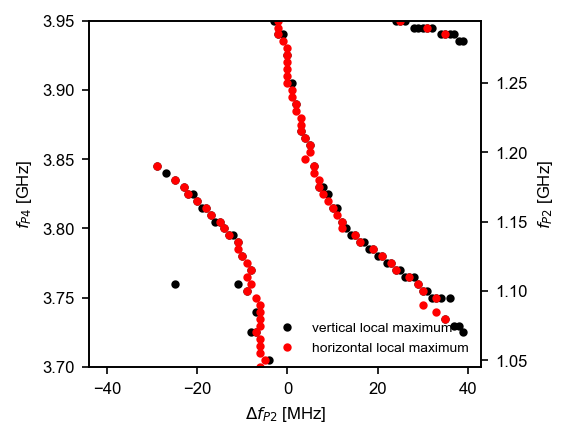

In [10]:
from scipy.signal import find_peaks

data_q2diff=loadtxt('mixing_set_delta_set_q2diff.dat') #load the data of the scan through the bichromatic line 
fp4_q2diff=data_q2diff[:,0]
dfp2_q2diff=data_q2diff[:,1]
p_q2diff=data_q2diff[:,2]

fig, ax = plt.subplots()
ax2=ax.twinx()

x=dfp2_q2diff
y=fp4_q2diff
z=p_q2diff


xr = np.reshape(x,(140, 80))
yr = np.reshape(y,(140, 80))
zr = np.reshape(z,(140, 80))

x_fit1=[]        #these lists will contain the coordinates of the vertical and horizontal local maximums 
y_fit1=[]

x_fit2=[]
y_fit2=[]

for i in range(0,80):
    peaks, _ = find_peaks(zr[:,i],height=0.15,width=1,distance=2,prominence=0.15) #this function finds the vertical peaks, the maximums
    for j in peaks:
        #ax.scatter(xr[j,i]*10**(-6),yr[j,i]*10**(-9),marker='.',color='black')
        x_fit1.append(xr[j,i])
        y_fit1.append(yr[j,i])   
for i in range(0,140):
    peaks, _ = find_peaks(zr[i,:],height=0.15,width=1,distance=2,prominence=0.15)  #find the horizontal peaks
    for j in peaks:
        #ax.scatter(xr[i,j]*10**(-6),yr[i,j]*10**(-9),marker='.',color='red')
        x_fit2.append(xr[i,j])
        y_fit2.append(yr[i,j])

x_fit=merge_lists(x_fit1,x_fit2,y_fit1,y_fit2)[0]  #we add together the horizontal and vertical peaks, counting only once
y_fit=merge_lists(x_fit1,x_fit2,y_fit1,y_fit2)[1]

x_fit1=array(x_fit1)
x_fit2=array(x_fit2)
y_fit1=array(y_fit1)
y_fit2=array(y_fit2)
        
ax.plot(x_fit1*10**(-6),y_fit1*10**(-9),linestyle='',marker='.',color='black',label='vertical local maximum') #plot the results
ax.plot(x_fit2*10**(-6),y_fit2*10**(-9),linestyle='',marker='.',color='red',label='horizontal local maximum')
        
x_fit=array(x_fit)
y_fit=array(y_fit)
#print(len(zr[:,0]))

ax2.set_ylim(3.7-fq2,3.95-fq2)
ax.set_ylim(3.7,3.95)
ax.set_xlabel(r'$\Delta f_{P2}$ [MHz]')
ax2.set_ylabel(r'$f_{P2}$ [GHz]')
ax.set_ylabel(r'$f_{P4}$ [GHz]')
ax.legend()

The find_peaks function succesfully finds the anticrossing, but also finds other resonances and noise, which we do not want to fit. Therefore we have to drop those points manually.  

[ 2.21253514e+06 -3.80349693e+09  1.75970073e+07]
[  92502.82069493 1688481.09479587  246193.87420642]


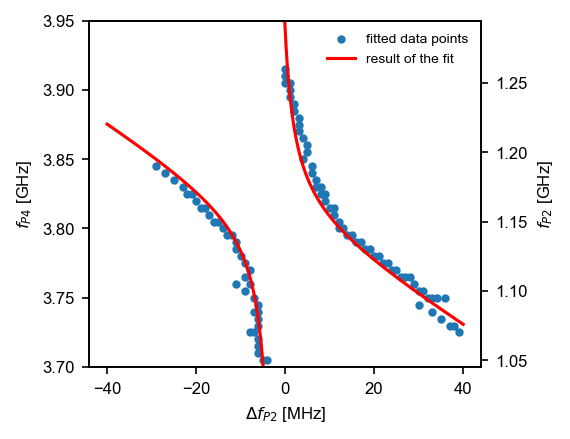

In [11]:
#drop the points of the other resonance lines 
fig, ax = plt.subplots()
ax2=ax.twinx()

x_fit_up=[]
x_fit_down=[]
y_fit_up=[]
y_fit_down=[]
x_fit_all=[]
y_fit_all=[]
for i in range(0,len(x_fit)):   #we go through the found points 
    if y_fit[i]>3.7e9 and y_fit[i]<3.92e9:                 #we keep this range
        if not(x_fit[i]>2e7 and y_fit[i]>3.9e9) and not(x_fit[i]<-2e7 and y_fit[i]<3.78e9): #drop these points
            x_fit_all.append(x_fit[i])
            y_fit_all.append(y_fit[i])
            if x_fit[i]>-0.4e7:
                x_fit_up.append(x_fit[i])
                y_fit_up.append(y_fit[i])
            else:
                x_fit_down.append(x_fit[i])
                y_fit_down.append(y_fit[i])
#scatter(x_fit_up,y_fit_up,marker='.')
#scatter(x_fit_down,y_fit_down,marker='.')
x_fit_all=array(x_fit_all)
y_fit_all=array(y_fit_all)

ax.scatter(x_fit_all*10**(-6),y_fit_all*10**(-9),marker='.',label='fitted data points') #show the remaining points 


def curve_q2diff(x,b0,b1,chi3):                     #theoretical curve used for fitting the anticrossings 
    return (chi3**2-(2*b0+b1)*x-b0*b1-2*x**2)/(x+b0)

popt,pcov=curve_fit(curve_q2diff,x_fit_all,y_fit_all,p0=[2.19e6,-3.8e9,19.19e6]) #fit of the anticrossing 
perr=sqrt(diag(pcov))


x1=linspace(-4*10**7,-0.4*10**7,5000)
x2=linspace(-0.1*10**7,4*10**7,5000)

ax.plot(x1*10**(-6),curve_q2diff(x1,popt[0],popt[1],popt[2])*10**(-9),color='red',label='result of the fit') #plot the result
ax.plot(x2*10**(-6),curve_q2diff(x2,popt[0],popt[1],popt[2])*10**(-9),color='red')

print(popt)
print(perr)

chi3_AC5=popt[2]
b0_AC5=popt[0]
b1_AC5=popt[1]

ax2.set_ylim(3.7-fq2,3.95-fq2)
ax.set_ylim(3.7,3.95)
ax.set_xlabel(r'$\Delta f_{P2}$ [MHz]')
ax2.set_ylabel(r'$f_{P2}$ [GHz]')
ax.set_ylabel(r'$f_{P4}$ [GHz]')
ax.legend()
#xlim(-4e7,4e7)

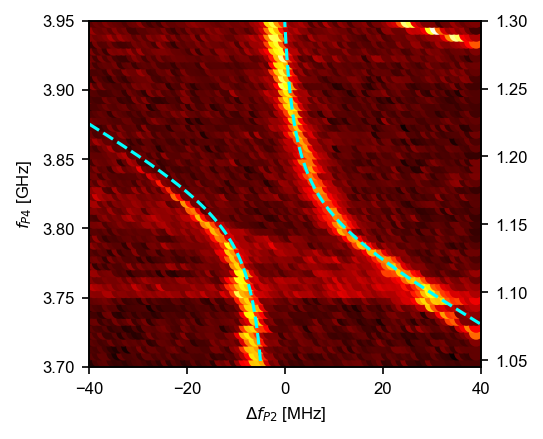

In [12]:
fig, ax = plt.subplots()
ax2=ax.twinx()

dfp2_q2diffr = np.reshape(dfp2_q2diff,(80, 140))
fp4_q2diffr = np.reshape(fp4_q2diff,(80, 140))
p_q2diffr = np.reshape(p_q2diff,(80, 140))

rbf = scipy.interpolate.Rbf(dfp2_q2diffr*10e-6, fp4_q2diffr*10e-9, p_q2diffr, function='linear')

zi = rbf(dfp2_q2diffr*10e-6, fp4_q2diffr*10e-9)


x1=linspace(-4*10**7,-0.4*10**7,5000)
x2=linspace(-0.1*10**7,4*10**7,5000)

ax.plot(x1*10**(-6),curve_q2diff(x1,popt[0],popt[1],popt[2])*10**(-9),linestyle='dashed',color='cyan')  #plot the result
ax.plot(x2*10**(-6),curve_q2diff(x2,popt[0],popt[1],popt[2])*10**(-9),linestyle='dashed',color='cyan')
ax.imshow(zi, vmin=p_q2diffr.min(), vmax=p_q2diffr.max(), origin='lower',aspect='auto',
           extent=[dfp2_q2diffr.min(), dfp2_q2diffr.max(), fp4_q2diffr.min(), fp4_q2diffr.max()])

ax.scatter(dfp2_q2diffr*10**(-6), fp4_q2diffr*10**(-9), c=p_q2diffr,cmap='hot')  #plot the heatmap 

ax.set_ylim(3.7,3.92)
ax.set_xlim(dfp2_q2diffr.min()*10**(-6),dfp2_q2diffr.max()*10**(-6))
ax2.set_ylim(3.7-fq2,3.92-fq2)

ax.set_xlabel(r'$\Delta f_{P2}$ [MHz]')
#ax2.set_ylabel(r'$f_{P2}$ [GHz]')
ax.set_ylabel(r'$f_{P4}$ [GHz]')

ax.set_xticks([-40,-20,0,20,40])
ax.set_yticks([3.70,3.75,3.80,3.85,3.90,3.95])
ax2.set_yticks([1.05,1.10,1.15,1.20,1.25,1.30])

fig.savefig('anticrossing_lowerq2diff_fit.pdf',format='pdf',dpi=300,bbox_inches="tight")
fig.savefig('anticrossing_lowerq2diff_fit.png',format='png',dpi=300,bbox_inches="tight")

## Anticrossing AC3

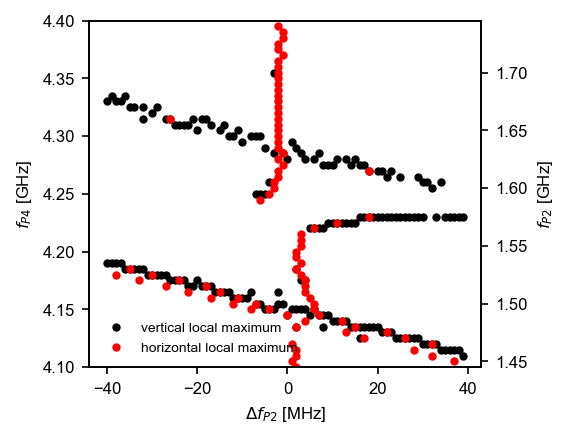

In [13]:
data_q2diff=loadtxt('mixing_set_delta_set_q2diff.dat') #load the data 
fp4_q2diff=data_q2diff[:,0]
dfp2_q2diff=data_q2diff[:,1]
p_q2diff=data_q2diff[:,2]
pmax_q2diff=max(p_q2diff)

fig, ax = plt.subplots()
ax2=ax.twinx()

x=dfp2_q2diff
y=fp4_q2diff
z=p_q2diff

xr=np.reshape(x,(140, 80))
yr=np.reshape(y,(140, 80))
zr=np.reshape(z,(140, 80))

dfp2_q2diffr = np.reshape(dfp2_q2diff,(140, 80))
fp4_q2diffr = np.reshape(fp4_q2diff,(140, 80))
p_q2diffr = np.reshape(p_q2diff,(140, 80))

x_fit1=[]
x_fit2=[]
y_fit1=[]
y_fit2=[]

for i in range(0,80):
    peaks, _ = find_peaks(zr[:,i],height=0.1,width=1,distance=2,prominence=0.15)  #we find vertical the peaks
    for j in peaks:
        #scatter(xr[j,i],yr[j,i],marker='.',color='black')
        x_fit1.append(xr[j,i])
        y_fit1.append(yr[j,i])
        
for i in range(0,140):
    peaks, _ = find_peaks(zr[i,:],height=0.1,width=1,distance=2,prominence=0.15)  #we find the horizontal peaks 
    for j in peaks:
        #scatter(xr[i,j],yr[i,j],marker='.',color='red')
        x_fit2.append(xr[i,j])
        y_fit2.append(yr[i,j])
        
x_fit=merge_lists(x_fit1,x_fit2,y_fit1,y_fit2)[0]    #add together the horizontal and vertical points 
y_fit=merge_lists(x_fit1,x_fit2,y_fit1,y_fit2)[1]

x_fit1=array(x_fit1)
y_fit1=array(y_fit1)
x_fit2=array(x_fit2)
y_fit2=array(y_fit2)

ax.plot(x_fit1*10**(-6),y_fit1*10**(-9),linestyle='',marker='.',color='black',label='vertical local maximum') #plot the results
ax.plot(x_fit2*10**(-6),y_fit2*10**(-9),linestyle='',marker='.',color='red',label='horizontal local maximum')

x_fit=array(x_fit)
y_fit=array(y_fit)
        
ax2.set_ylim(4.1-fq2,4.4-fq2)
ax.set_ylim(4.1,4.4)
ax.set_xlabel(r'$\Delta f_{P2}$ [MHz]')
ax2.set_ylabel(r'$f_{P2}$ [GHz]')
ax.set_ylabel(r'$f_{P4}$ [GHz]')
ax.legend()

[3.71113340e+05 4.23382992e+09 9.30685599e+06]
[ 130824.90437646 1773135.89217386  273681.71982925]


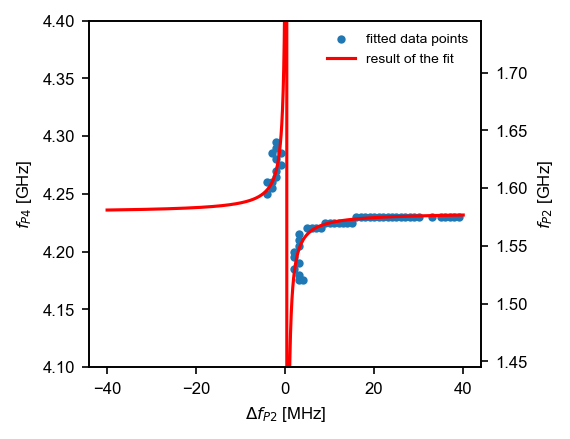

In [14]:
#manually drop the data points which are coming from another resonance line
fig, ax = plt.subplots()
ax2=ax.twinx()

def curve_q2diff(x,x0,y0,chi3):  #theoretical function used for the fitting 
    return y0-chi3**2/(x-x0)

x_fit_all=[]
y_fit_all=[]

for i in range(0,len(x_fit)):  #drop the points which come from another resonance 
    if not (x_fit[i]<-0.45*10**7 and y_fit[i]>4.28*10**7) and not(x_fit[i]>-0.05*10**7 and y_fit[i]>4.245*10**9):
        if y_fit[i]>4.17*10**9 and y_fit[i]<4.3*10**9: 
            x_fit_all.append(x_fit[i])
            y_fit_all.append(y_fit[i])
            
popt,pcov=curve_fit(curve_q2diff,x_fit_all,y_fit_all,p0=[0.42*10**6,4.23*10**9,8.96*10**6]) #fit the result 
perr=sqrt(diag(pcov))

print(popt)
print(perr)

chi3_AC3=popt[2]
x0_AC3=popt[0]
y0_AC3=popt[1]

dfp2=linspace(-4*10**7,4*10**7,5000)

x_fit_all=array(x_fit_all)
y_fit_all=array(y_fit_all)

ax.scatter(x_fit_all*10**(-6),y_fit_all*10**(-9),marker='.',label='fitted data points') #plot the fitted data points 
ax.plot(dfp2*10**(-6),curve_q2diff(dfp2,popt[0],popt[1],popt[2])*10**(-9),color='red',label='result of the fit') #result of the fit

ax2.set_ylim(4.1-fq2,4.4-fq2)
ax.set_ylim(4.1,4.4)
ax.set_xlabel(r'$\Delta f_{P2}$ [MHz]')
ax2.set_ylabel(r'$f_{P2}$ [GHz]')
ax.set_ylabel(r'$f_{P4}$ [GHz]')
ax.legend()

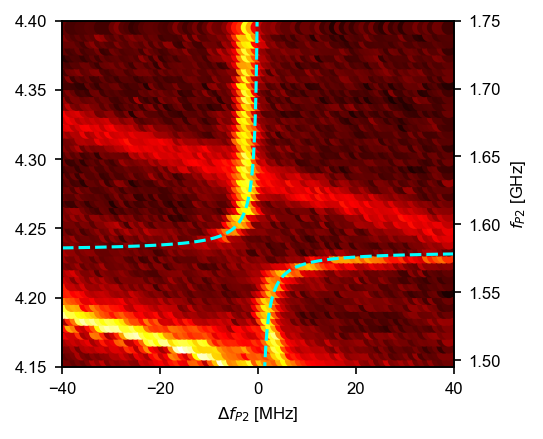

In [15]:
fig, ax = plt.subplots()
ax2=ax.twinx()

dfp2_q2diffr = np.reshape(dfp2_q2diff,(80, 140))
fp4_q2diffr = np.reshape(fp4_q2diff,(80, 140))
p_q2diffr = np.reshape(p_q2diff,(80, 140))

rbf = scipy.interpolate.Rbf(dfp2_q2diffr*10e-6, fp4_q2diffr*10e-9, p_q2diffr, function='linear') 

zi = rbf(dfp2_q2diffr*10e-6, fp4_q2diffr*10e-9)

#chi3_11=uev_to_Hz(0.101)


x1=linspace(-4*10**7,0.0*10**7,5000)
x2=linspace(0.1*10**7,4*10**7,5000)

ax.plot(x1*10**(-6),curve_q2diff(x1,popt[0],popt[1],popt[2])*10**(-9),linestyle='dashed',color='cyan') #plot the result of the fit
ax.plot(x2*10**(-6),curve_q2diff(x2,popt[0],popt[1],popt[2])*10**(-9),linestyle='dashed',color='cyan')
ax.imshow(zi, vmin=p_q2diffr.min(), vmax=p_q2diffr.max(), origin='lower',aspect='auto',
           extent=[dfp2_q2diffr.min(), dfp2_q2diffr.max(), fp4_q2diffr.min(), fp4_q2diffr.max()])

ax.scatter(dfp2_q2diffr*10**(-6), fp4_q2diffr*10**(-9), c=p_q2diffr,cmap='hot') #plot the heatmap 

ax.set_ylim(4.15,4.4)
ax.set_xlim(dfp2_q2diffr.min()*10**(-6),dfp2_q2diffr.max()*10**(-6))
ax2.set_ylim(4.15-fq2,4.4-fq2)

ax.set_xlabel(r'$\Delta f_{P2}$ [MHz]')
ax2.set_ylabel(r'$f_{P2}$ [GHz]')
#ax.set_ylabel(r'$f_{P4}$ [GHz]')

ax.set_xticks([-40,-20,0,20,40])
ax.set_yticks([4.15,4.20,4.25,4.30,4.35,4.40])
ax2.set_yticks([1.50,1.55,1.60,1.65,1.70,1.75])

fig.savefig('anticrossing_upperq2diff_fit.pdf',format='pdf',dpi=300,bbox_inches="tight")
fig.savefig('anticrossing_upperq2diff_fit.png',format='png',dpi=300,bbox_inches="tight")


## Anticrossing AC1

In [16]:
data_q2sum=loadtxt('mixing_set_delta_set_q2sum.dat')  #load the data 
fp4_q2sum=data_q2sum[:,0]
dfp2_q2sum=data_q2sum[:,1]
p_q2sum=data_q2sum[:,2]

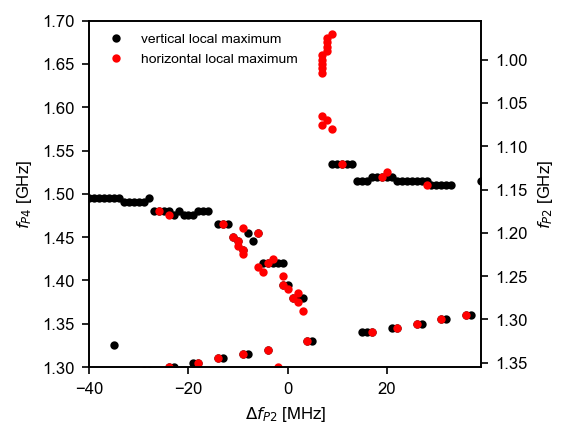

In [17]:
x=dfp2_q2sum
y=fp4_q2sum
z=p_q2sum

fig, ax = plt.subplots()
ax2=ax.twinx()

xr=np.reshape(x,(200, 80))
yr=np.reshape(y,(200, 80))
zr=np.reshape(z,(200, 80))

x_fit1=[]
x_fit2=[]
y_fit1=[]
y_fit2=[]

for i in range(0,80):
    peaks, _ = find_peaks(zr[:,i],height=0.5,width=1,distance=3,prominence=0.35)  #find the vertical peaks 
    for j in peaks:
        #scatter(xr[j,i],yr[j,i],marker='.',color='black')
        x_fit1.append(xr[j,i])
        y_fit1.append(yr[j,i])
        
for i in range(0,200):
    peaks, _ = find_peaks(zr[i,:],height=0.5,width=1,distance=3,prominence=0.35)  #find the horizontal peaks 
    for j in peaks:
        #scatter(xr[i,j],yr[i,j],marker='.',color='red')
        x_fit2.append(xr[i,j])
        y_fit2.append(yr[i,j])
        
x_fit=merge_lists(x_fit1,x_fit2,y_fit1,y_fit2)[0]  #add together the vertical and horizontal peaks 
y_fit=merge_lists(x_fit1,x_fit2,y_fit1,y_fit2)[1]

x_fit1=array(x_fit1)
x_fit2=array(x_fit2)
y_fit1=array(y_fit1)
y_fit2=array(y_fit2)

ax.plot(x_fit1*10**(-6),y_fit1*10**(-9),linestyle='',marker='.',color='black',label='vertical local maximum') #plot the results
ax.plot(x_fit2*10**(-6),y_fit2*10**(-9),linestyle='',marker='.',color='red',label='horizontal local maximum')

x_fit=array(x_fit)
y_fit=array(y_fit)
        
ax.set_ylim(1.3,1.7)
ax.set_xlim(dfp2_q2diffr.min()*10**(-6),dfp2_q2diffr.max()*10**(-6))
ax2.set_ylim(-1.3+fq2,-1.7+fq2)

ax.set_xlabel(r'$\Delta f_{P2}$ [MHz]')
ax2.set_ylabel(r'$f_{P2}$ [GHz]')
ax.set_ylabel(r'$f_{P4}$ [GHz]')
ax.legend()

[4.91727609e+06 1.48914763e+09 1.88691804e+07]
[ 132189.80070144 3203127.59350925  442156.36863657]


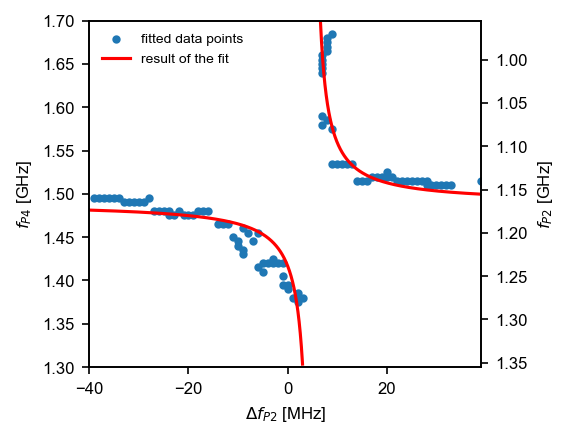

In [18]:
#manually remove the data points that correspond to another resonances and noise 
x_fit_all=[]
y_fit_all=[]

fig, ax = plt.subplots()
ax2=ax.twinx()

def curve_q2sum(x,x0,y0,chi3):
    return y0+chi3**2/(x-x0)

for i in range(0,len(x_fit)):
    if y_fit[i]>1.37*10**9 and y_fit[i]<1.7*10**9: #drop the points which come from another resonance 
        if x_fit[i]>-4*10**7 and x_fit[i]<4*10**7:
            if not (y_fit[i]<1.4*10**9 and x_fit[i]<-1*10**7):
                x_fit_all.append(x_fit[i])
                y_fit_all.append(y_fit[i])
            
popt,pcov=curve_fit(curve_q2sum,x_fit_all,y_fit_all,p0=[4.5*10**6,1.49*10**9,19.7*10**6])  #fit the data points 
perr=sqrt(diag(pcov))

print(popt)
print(perr)

chi3_AC1=popt[2]
x0_AC1=popt[0]
y0_AC1=popt[1]

x1=linspace(-4*10**7,0.3*10**7,5000)
x2=linspace(0.5*10**7,4*10**7,5000)

x_fit_all=array(x_fit_all)
y_fit_all=array(y_fit_all)

ax.scatter(x_fit_all*10**(-6),y_fit_all*10**(-9),marker='.',label='fitted data points') #plot the fitted data points 
ax.plot(x1*10**(-6),curve_q2sum(x1,popt[0],popt[1],popt[2])*10**(-9),color='red',label='result of the fit') #plot the result
ax.plot(x2*10**(-6),curve_q2sum(x2,popt[0],popt[1],popt[2])*10**(-9),color='red')

ax.set_ylim(1.3,1.7)
ax.set_xlim(dfp2_q2diffr.min()*10**(-6),dfp2_q2diffr.max()*10**(-6))
ax2.set_ylim(-1.3+fq2,-1.7+fq2)

ax.set_xlabel(r'$\Delta f_{P2}$ [MHz]')
ax2.set_ylabel(r'$f_{P2}$ [GHz]')
ax.set_ylabel(r'$f_{P4}$ [GHz]')
ax.legend()

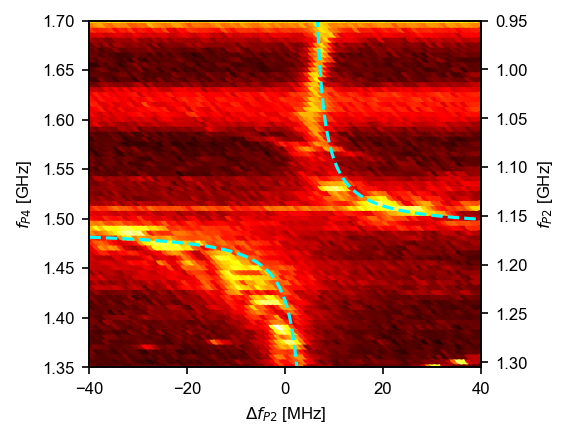

In [19]:
fig, ax = plt.subplots()
ax2=ax.twinx()

dfp2_q2sumr = np.reshape(dfp2_q2sum,(80, 200))
fp4_q2sumr = np.reshape(fp4_q2sum,(80, 200))
p_q2sumr = np.reshape(p_q2sum,(80, 200))

rbf = scipy.interpolate.Rbf(dfp2_q2sumr*10e-6, fp4_q2sumr*10e-9, p_q2sumr, function='linear')

zi = rbf(dfp2_q2sumr*10e-6, fp4_q2sumr*10e-9)

#chi3_11=uev_to_Hz(0.101)


x1=linspace(-4*10**7,0.3*10**7,5000)
x2=linspace(0.5*10**7,4*10**7,5000)

ax.plot(x1*10**(-6),curve_q2sum(x1,popt[0],popt[1],popt[2])*10**(-9),linestyle='dashed',color='cyan') #plot the result of the fit
ax.plot(x2*10**(-6),curve_q2sum(x2,popt[0],popt[1],popt[2])*10**(-9),linestyle='dashed',color='cyan')
ax.imshow(zi, vmin=p_q2sumr.min(), vmax=p_q2sumr.max(), origin='lower',aspect='auto',
           extent=[dfp2_q2sumr.min(), dfp2_q2sumr.max(), fp4_q2sumr.min(), fp4_q2sumr.max()])

ax.scatter(dfp2_q2sumr*10**(-6), fp4_q2sumr*10**(-9), c=p_q2sumr,cmap='hot') #plot the colormap 

ax.set_ylim(1.35,1.7)
ax.set_xlim(dfp2_q2sumr.min()*10**(-6),dfp2_q2sumr.max()*10**(-6))
ax2.set_ylim(-1.35+fq2,-1.7+fq2)

ax.set_xlabel(r'$\Delta f_{P2}$ [MHz]')
ax2.set_ylabel(r'$f_{P2}$ [GHz]')
ax.set_ylabel(r'$f_{P4}$ [GHz]')

ax.set_xticks([-40,-20,0,20,40])
ax.set_yticks([1.35,1.40,1.45,1.50,1.55,1.60,1.65,1.70])
ax2.set_yticks([0.95,1.00,1.05,1.10,1.15,1.20,1.25,1.30])

fig.savefig('Q2sum.pdf',format='pdf',dpi=300,bbox_inches="tight")
fig.savefig('Q2sum.png',format='png',dpi=300,bbox_inches="tight")

## Anticrossing AC4

In [20]:
data_q2sum=loadtxt('mixing_set_delta_set_q2sum.dat')  
fp4_q2sum=data_q2sum[:,0]
dfp2_q2sum=data_q2sum[:,1]
p_q2sum=data_q2sum[:,2]
pmax_q2sum=max(p_q2sum)

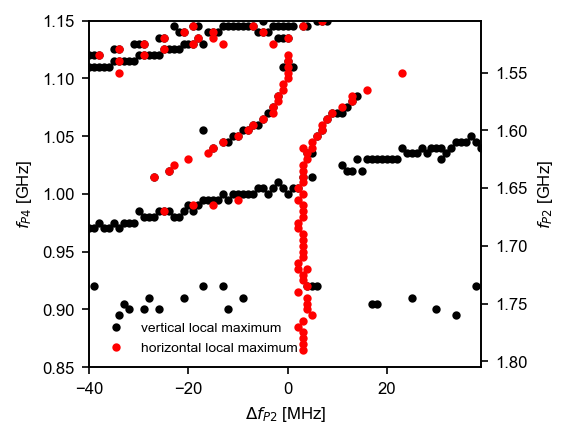

In [21]:
fig, ax = plt.subplots()
ax2=ax.twinx()

dfp2_q2sumr = np.reshape(dfp2_q2sum,(80, 200))
fp4_q2sumr = np.reshape(fp4_q2sum,(80, 200))
p_q2sumr = np.reshape(p_q2sum,(80, 200))

x_fit1=[]
x_fit2=[]
y_fit1=[]
y_fit2=[]

x=dfp2_q2sumr
y=fp4_q2sumr
z=p_q2sumr

xr=np.reshape(x,(200, 80))
yr=np.reshape(y,(200, 80))
zr=np.reshape(z,(200, 80))

for i in range(0,80):
    peaks, _ = find_peaks(zr[:,i],height=0.1,width=1,distance=1,prominence=0.11) #find the vertical peaks 
    for j in peaks:
        #scatter(xr[j,i],yr[j,i],marker='.',color='black')
        x_fit1.append(xr[j,i])
        y_fit1.append(yr[j,i])
        
for i in range(0,200):
    peaks, _ = find_peaks(zr[i,:],height=0.1,width=1,distance=1,prominence=0.11)  #find the horizontal peaks 
    for j in peaks:
        #scatter(xr[i,j],yr[i,j],marker='.',color='red')
        x_fit2.append(xr[i,j])
        y_fit2.append(yr[i,j])
        
x_fit=merge_lists(x_fit1,x_fit2,y_fit1,y_fit2)[0]  #merge the vertical and horizontal peaks 
y_fit=merge_lists(x_fit1,x_fit2,y_fit1,y_fit2)[1]
        
x_fit1=array(x_fit1)
x_fit2=array(x_fit2)
y_fit1=array(y_fit1)
y_fit2=array(y_fit2)

ax.plot(x_fit1*10**(-6),y_fit1*10**(-9),linestyle='',marker='.',color='black',label='vertical local maximum') #plot the peaks 
ax.plot(x_fit2*10**(-6),y_fit2*10**(-9),linestyle='',marker='.',color='red',label='horizontal local maximum')
        
ax.set_ylim(0.85,1.15)
ax.set_xlim(dfp2_q2sumr.min()*10**(-6),dfp2_q2sumr.max()*10**(-6))
ax2.set_ylim(-0.85+fq2,-1.15+fq2)

ax.set_xlabel(r'$\Delta f_{P2}$ [MHz]')
ax2.set_ylabel(r'$f_{P2}$ [GHz]')
ax.set_ylabel(r'$f_{P4}$ [GHz]')
ax.legend()

[ 1.49801205e+06 -1.06206600e+09  8.88736725e+06]
[  92776.69062588 1477558.13684788  199148.62937947]


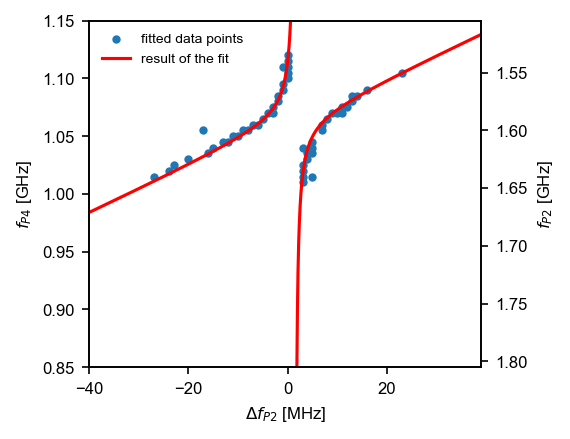

In [22]:
#manually dropping the resonance points which correspond to another resonance lines 
x_fit_all=[]
y_fit_all=[]

fig, ax = plt.subplots()
ax2=ax.twinx()

def curve_q2sum(x,b0,b1,chi3):                        #theoretical curve used for the fitting of the anticrossing 
    return (chi3**2+(2*b0+b1)*x-b0*b1-2*x**2)/(b0-x)

for i in range(0,len(x_fit)):
    if (y_fit[i]>1*10**9 and y_fit[i]<1.13*10**9):  #keep this range and drop the points coming from another resonance 
        if not(x_fit[i]>0.5*10**7 and y_fit[i]<1.052*10**9) and not(y_fit[i]<1.02*10**9 and (x_fit[i]<0.1*10**7 and x_fit[i]>-2.6*10**7)) and not(x_fit[i]<-1.7*10**7 and y_fit[i]>1.05*10**9):
            if not(y_fit[i]>1.1*10**9 and x_fit[i]<-2*10**7) and not(y_fit[i]<1*10**9 and x_fit[i]<-2*10**7) and not(x_fit[i]>0.0*10**7 and x_fit[i]<0.3*10**7):
                x_fit_all.append(x_fit[i])
                y_fit_all.append(y_fit[i])

x_fit_all=array(x_fit_all)
y_fit_all=array(y_fit_all)
                
ax.scatter(x_fit_all*10**(-6),y_fit_all*10**(-9),marker='.',label='fitted data points') #plot the fitted data points 

popt,pcov=curve_fit(curve_q2sum,x_fit_all,y_fit_all,p0=[1.91*10**6,-1.06*10**9,8.9*10**6])
perr=sqrt(diag(pcov))

chi3_AC4=popt[2]
b0_AC4=popt[0]
b1_AC4=popt[1]

print(popt)
print(perr)

x1=linspace(-4*10**7,0.08*10**7,5000)
x2=linspace(0.15*10**7,4*10**7,5000)
ax.plot(x1*10**(-6),curve_q2sum(x1,popt[0],popt[1],popt[2])*10**(-9),color='red',label='result of the fit') #plot the result of the fit
ax.plot(x2*10**(-6),curve_q2sum(x2,popt[0],popt[1],popt[2])*10**(-9),color='red')

ax.set_ylim(0.85,1.15)
ax.set_xlim(dfp2_q2sumr.min()*10**(-6),dfp2_q2sumr.max()*10**(-6))
ax2.set_ylim(-0.85+fq2,-1.15+fq2)

ax.set_xlabel(r'$\Delta f_{P2}$ [MHz]')
ax2.set_ylabel(r'$f_{P2}$ [GHz]')
ax.set_ylabel(r'$f_{P4}$ [GHz]')
ax.legend()

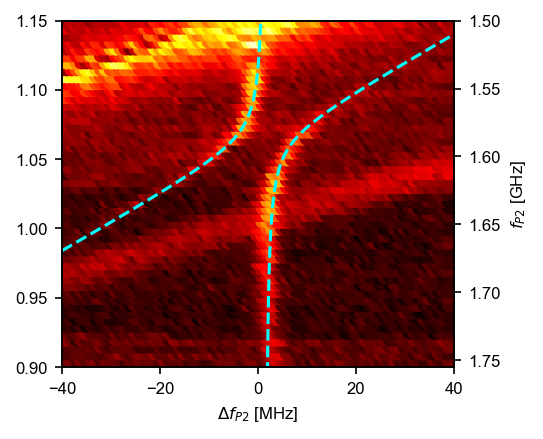

In [23]:
fig, ax = plt.subplots()
ax2=ax.twinx()

dfp2_q2sumr = np.reshape(dfp2_q2sum,(80, 200))
fp4_q2sumr = np.reshape(fp4_q2sum,(80, 200))
p_q2sumr = np.reshape(p_q2sum,(80, 200))

rbf = scipy.interpolate.Rbf(dfp2_q2sumr*10e-6, fp4_q2sumr*10e-9, p_q2sumr, function='linear')

zi = rbf(dfp2_q2sumr*10e-6, fp4_q2sumr*10e-9)

x1=linspace(-4*10**7,0.08*10**7,5000)
x2=linspace(0.15*10**7,4*10**7,5000)

ax.plot(x1*10**(-6),curve_q2sum(x1,popt[0],popt[1],popt[2])*10**(-9),linestyle='dashed',color='cyan') #plot the result of the fit
ax.plot(x2*10**(-6),curve_q2sum(x2,popt[0],popt[1],popt[2])*10**(-9),linestyle='dashed',color='cyan')
ax.imshow(zi, vmin=p_q2sumr.min(), vmax=p_q2sumr.max(), origin='lower',aspect='auto',
           extent=[dfp2_q2sumr.min(), dfp2_q2sumr.max(), fp4_q2sumr.min(), fp4_q2sumr.max()])

ax.scatter(dfp2_q2sumr*10**(-6), fp4_q2sumr*10**(-9), c=p_q2sumr,cmap='hot')  #plot the heatmap 

ax.set_ylim(0.9,1.15)
ax.set_xlim(dfp2_q2sumr.min()*10**(-6),dfp2_q2sumr.max()*10**(-6))
ax2.set_ylim(-0.9+fq2,-1.15+fq2)

ax.set_xlabel(r'$\Delta f_{P2}$ [MHz]')
ax2.set_ylabel(r'$f_{P2}$ [GHz]')
#ax.set_ylabel(r'$f_{P4}$ [GHz]')

fig.savefig('anticrossing_lowerq2sum_fit.png', format='png', dpi=300,bbox_inches="tight")
fig.savefig('anticrossing_lowerq2sum_fit.pdf', format='pdf', dpi=300,bbox_inches="tight")

ax.set_xticks([-40,-20,0,20,40])
ax.set_yticks([0.90,0.95,1.00,1.05,1.10,1.15])
ax2.set_yticks([1.50,1.55,1.60,1.65,1.70,1.75])

## Anticrossing AC2

In [24]:
data11=loadtxt('mixing_set_delta_set_q1diff_11.dat')  #load the anticrossing data at detunings ranging from (-11,11) to (-7,7)
fp4_11=data11[:,0]
dfp2_11=data11[:,1]
p_11=data11[:,2]
pmax_11=max(p_11)

data10=loadtxt('mixing_set_delta_set.dat')
fp4_10=data10[:,0]
dfp2_10=data10[:,1]
p_10=data10[:,2]
pmax_10=max(p_10)

data9=loadtxt('mixing_set_delta_set_q1diff_9.dat')
fp4_9=data9[:,0]
dfp2_9=data9[:,1]
p_9=data9[:,2]
pmax_9=max(p_9)

data8=loadtxt('mixing_set_delta_set_q1diff_8.dat')
fp4_8=data8[:,0]
dfp2_8=data8[:,1]
p_8=data8[:,2]
pmax_8=max(p_8)

data7=loadtxt('mixing_set_delta_set_q1diff_7.dat')
fp4_7=data7[:,0]
dfp2_7=data7[:,1]
p_7=data7[:,2]
pmax_7=max(p_7)

## (-11,11) detuning point

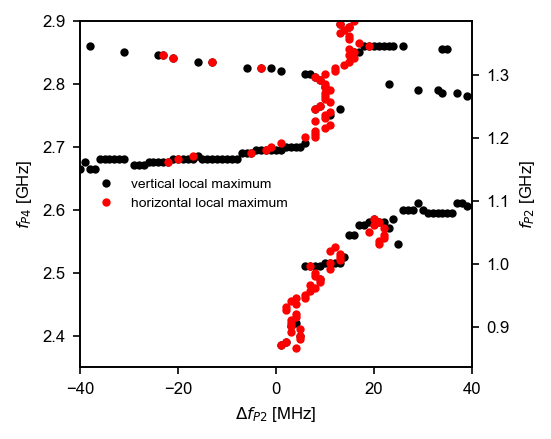

In [25]:
x=dfp2_11
y=fp4_11
z=p_11

x_fit1=[]
x_fit2=[]
y_fit1=[]
y_fit2=[]

fig, ax = plt.subplots()
ax2=ax.twinx()

xr=np.reshape(x,(300, 80))
yr=np.reshape(y,(300, 80))
zr=np.reshape(z,(300, 80))

for i in range(0,80):
    peaks, _ = find_peaks(zr[:,i],height=0.3,width=1,distance=1,prominence=0.25) #find vertical peaks 
    for j in peaks:
        #scatter(xr[j,i],yr[j,i],marker='.',color='black')
        x_fit1.append(xr[j,i])
        y_fit1.append(yr[j,i])
        
for i in range(0,300):
    peaks, _ = find_peaks(zr[i,:],height=0.3,width=1,distance=1,prominence=0.25) #find horizontal peaks 
    for j in peaks:
        #scatter(xr[i,j],yr[i,j],marker='.',color='red')
        x_fit2.append(xr[i,j])
        y_fit2.append(yr[i,j])
        
x_fit=merge_lists(x_fit1,x_fit2,y_fit1,y_fit2)[0]  #merge the vertical and horizontal peaks 
y_fit=merge_lists(x_fit1,x_fit2,y_fit1,y_fit2)[1]

x_fit1=array(x_fit1)
x_fit2=array(x_fit2)
y_fit1=array(y_fit1)
y_fit2=array(y_fit2)

ax.plot(x_fit1*10**(-6),y_fit1*10**(-9),linestyle='',marker='.',color='black',label='vertical local maximum') #plot the found points
ax.plot(x_fit2*10**(-6),y_fit2*10**(-9),linestyle='',marker='.',color='red',label='horizontal local maximum')
        
ax.set_ylim(2.35,2.9)
ax.set_xlim(-40,40)
ax2.set_ylim(2.35-1.514,2.9-1.514)

ax.set_xlabel(r'$\Delta f_{P2}$ [MHz]')
ax2.set_ylabel(r'$f_{P2}$ [GHz]')
ax.set_ylabel(r'$f_{P4}$ [GHz]')
ax.legend()

The fitting of these attenuated anticrossings is much harder. We assume that the upper part of the anticrossing, which has higher fp2 frequency assumed to be without attenuation, while the lower part is attenuated. So we have to do two fittings with shared parameters, we use the symfit. The attenuated curve contains a lot of parameters, so we fix the $x_0$ values, which describes the asymptotic position of the lower part of the anticrossing, the $x_0$ values were chosen accordingly. 


Parameter Value        Standard Deviation
A         1.184748e+07 4.072831e+05
chi3      2.163016e+07 5.942358e+05
y0        2.675040e+09 9.853281e+05
Status message         Desired error not necessarily achieved due to precision loss.
Number of iterations   14
Objective              <symfit.core.objectives.LeastSquares object at 0x0000021D62578D30>
Minimizer              <symfit.core.minimizers.BFGS object at 0x0000021D6AD80670>

Goodness of fit qualifiers:
chi_squared            884934303138678.4
objective_value        442467151569339.2
r_squared              0.8999924251474761
OrderedDict([('A', 11847479.048683455), ('chi3', 21630159.370326538), ('y0', 2675040111.7585015)])


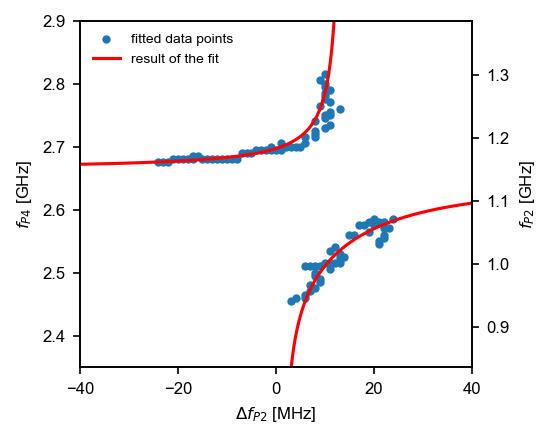

In [26]:
#manually drop the data points which come from another resonance
from symfit import variables, parameters, Fit, Model
from symfit import Parameter, Variable

fig, ax = plt.subplots()
ax2=ax.twinx()

x_fit_all=[]
y_fit_all=[]

dfp2_fit_11_u=[]  #this will contain data points of the upper part
dfp2_fit_11_d=[]  #this will contain data points of the lower part 
fp4_fit_11_u=[]
fp4_fit_11_d=[]

for i in range(0,len(x_fit)):  
    if (y_fit[i]>2.45*10**9 and y_fit[i]<2.82*10**9) and (x_fit[i]>-25*10**6 and x_fit[i]<25*10**6): #we keep this part 
        if not(x_fit[i]>2*10**7 and y_fit[i]>2.7*10**9) and not(y_fit[i]>2.75*10**9 and x_fit[i]<0.9*10**7): #drop the ones that come from another resonane
            x_fit_all.append(x_fit[i])
            y_fit_all.append(y_fit[i])
            
            if y_fit[i]>2.63*10**9:
                dfp2_fit_11_u.append(x_fit[i])
                fp4_fit_11_u.append(y_fit[i])
            else:
                dfp2_fit_11_d.append(x_fit[i])
                fp4_fit_11_d.append(y_fit[i])
        
        
dfp2_fit_11_u=array(dfp2_fit_11_u)
dfp2_fit_11_d=array(dfp2_fit_11_d)
fp4_fit_11_u=array(fp4_fit_11_u)
dfp2_fit_11_d=array(dfp2_fit_11_d)

x_u, x_d, y_u, y_d = variables('x_u, x_d, y_u, y_d')  

#x0=Parameter('x0',-3*10**7)
y0=Parameter('y0',2.65*10**9)  #these are the fitting parameters with initial guesses
A=Parameter('A',1*10**7)
chi3=Parameter('chi3',2*10**7)
#x0=Parameter('x0',0.3*10**7)

fc=1.05*10**9   #these are the parameters which describe the attenuation 
b=5.0*10**(-9)
fq1=1.514*10**9
x0=0.2*10**7

def x_1(y_u,y0,A,chi3):  #theoretical curve of the opper part of the attenuation, with 0 attenuation 
    return (x0*(y_u-y0)+pow(10,0*(y_u-fq1-fc))*(A*(x0+y_u-y0+A*pow(10,0*(y_u-fq1-fc)))-chi3**2))/(y_u-y0+A*10**(0*(y_u-fq1-fc)))

def x_2(y_d,y0,A,chi3):  #theoretical curve for the lower, attenuated part 
    return (x0*(y_d-y0)+pow(10,b*(y_d-fq1-fc))*(A*(x0+y_d-y0+A*pow(10,b*(y_d-fq1-fc)))-chi3**2))/(y_d-y0+A*10**(b*(y_d-fq1-fc)))

model = Model({
    x_u: (x0*(y_u-y0)+pow(10,0*(y_u-fq1-fc))*(A*(x0+y_u-y0+A*pow(10,0*(y_u-fq1-fc)))-chi3**2))/(y_u-y0+A*10**(0*(y_u-fq1-fc))),
    x_d:(x0*(y_d-y0)+pow(10,b*(y_d-fq1-fc))*(A*(x0+y_d-y0+A*pow(10,b*(y_d-fq1-fc)))-chi3**2))/(y_d-y0+A*10**(b*(y_d-fq1-fc))) ,
})
fit = Fit(model, x_u=dfp2_fit_11_u, x_d=dfp2_fit_11_d, y_u=fp4_fit_11_u, y_d=fp4_fit_11_d) #we do the fitting 
fit_result = fit.execute()

print(fit_result)
print(fit_result.params)

A_11=fit_result.params["A"]
chi3_11=fit_result.params["chi3"]
y0_11=fit_result.params["y0"]
x0_11=x0

chi3=2.163016e+07  #these are the results of the fit 
y0=2.675040e+09
A=1.184748e+07

chi3_11=chi3

x_fit_all=array(x_fit_all)
y_fit_all=array(y_fit_all)

ax.scatter(x_fit_all*10**(-6),y_fit_all*10**(-9),marker='.',label='fitted data points') #plot the fitted data points 

y1=linspace(2.67*10**9,2.9*10**9,5000)
y2=linspace(2.35*10**9,2.63*10**9,5000)

ax.plot(x_1(y1,y0,A,chi3)*10**(-6),y1*10**(-9),color='red',label='result of the fit')  #plot the result of the fit 
ax.plot(x_2(y2,y0,A,chi3)*10**(-6),y2*10**(-9),color='red')

ax.set_ylim(2.35,2.9)
ax.set_xlim(-40,40)
ax2.set_ylim(2.35-1.514,2.9-1.514)

ax.set_xlabel(r'$\Delta f_{P2}$ [MHz]')
ax2.set_ylabel(r'$f_{P2}$ [GHz]')
ax.set_ylabel(r'$f_{P4}$ [GHz]')
ax.legend()

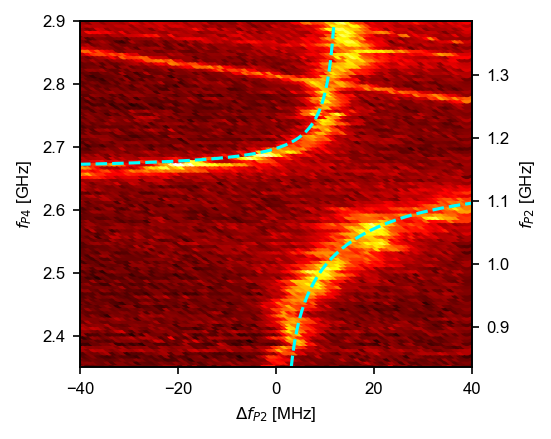

In [27]:
dfp2_11r = np.reshape(dfp2_11,(80, 300))
fp4_11r = np.reshape(fp4_11,(80, 300))
p_11r = np.reshape(p_11,(80, 300))

fig, ax = plt.subplots()
ax2=ax.twinx()
xlim(-40,40)

y1=linspace(2.667*10**9,2.9*10**9,5000)
y2=linspace(2.35*10**9,2.63*10**9,5000)

chi3=2.163016e+07
y0=2.675040e+09
A=1.184748e+07
#x0=2.435487e+06

rbf = scipy.interpolate.Rbf(dfp2_11r*10**(-6), fp4_11r*10**(-9), p_11r, function='linear')

zi = rbf(dfp2_11r*10**(-6), fp4_11r*10**(-9))

ax.plot(x_1(y1,y0,A,chi3)*10**(-6),y1*10**(-9),linestyle='dashed',color='cyan') #plot the result of the fitting 
ax.plot(x_2(y2,y0,A,chi3)*10**(-6),y2*10**(-9),linestyle='dashed',color='cyan')
ax.set_ylim(2.35,2.9)
ax.imshow(zi, vmin=p_11r.min(), vmax=p_11r.max(), origin='lower',aspect='auto',
           extent=[dfp2_11r.min()*10**(-6), dfp2_11r.max()*10**(-6), fp4_11r.min()*10**(-9), fp4_11r.max()*10**(-9)])

ax.scatter(dfp2_11r*10**(-6), fp4_11r*10**(-9), c=p_11r,cmap='hot') #plot the colormap 


ax.set_xlabel(r'$\Delta f_{P2}$ [MHz]')
ax.set_ylabel(r'$f_{P4}$ [GHz]')
ax2.set_ylim(2.35-1.514,2.9-1.514)
ax2.set_ylabel(r'$f_{P2}$ [GHz]')
#plt.colorbar()
#plt.show()
fig.savefig('anticrossing_11.png',format='png',dpi=300,bbox_inches="tight")
fig.savefig('anticrossing_11.pdf',format='pdf',dpi=300,bbox_inches="tight")

## (-10,10) detuning point

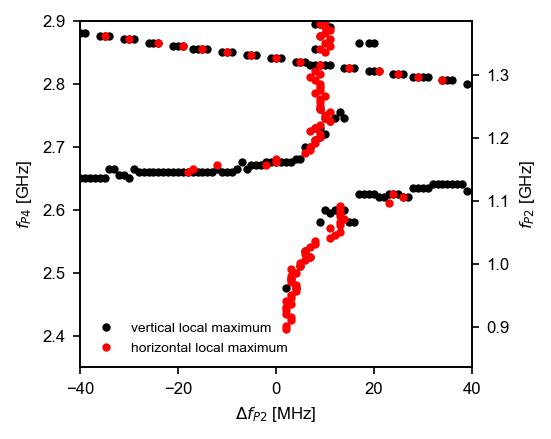

In [28]:
x=dfp2_10
y=fp4_10
z=p_10

fig, ax = plt.subplots()
ax2=ax.twinx()

xr=np.reshape(x,(300, 80))
yr=np.reshape(y,(300, 80))
zr=np.reshape(z,(300, 80))

x_fit=[]
y_fit=[]

x_fit1=[]
x_fit2=[]
y_fit1=[]
y_fit2=[]


for i in range(0,80):
    peaks, _ = find_peaks(zr[:,i],height=0.3,width=1,distance=1,prominence=0.2) #find the vertical peaks 
    for j in peaks:
        #scatter(xr[j,i],yr[j,i],marker='.',color='black')
        x_fit1.append(xr[j,i])
        y_fit1.append(yr[j,i])
        
for i in range(0,300):
    peaks, _ = find_peaks(zr[i,:],height=0.3,width=1,distance=1,prominence=0.2)  #find the horizontal peaks 
    for j in peaks:
        #scatter(xr[i,j],yr[i,j],marker='.',color='red')
        x_fit2.append(xr[i,j])
        y_fit2.append(yr[i,j])

x_fit=merge_lists(x_fit1,x_fit2,y_fit1,y_fit2)[0]  #merge the peaks 
y_fit=merge_lists(x_fit1,x_fit2,y_fit1,y_fit2)[1]

x_fit1=array(x_fit1)
x_fit2=array(x_fit2)
y_fit1=array(y_fit1)
y_fit2=array(y_fit2)

ax.plot(x_fit1*10**(-6),y_fit1*10**(-9),linestyle='',marker='.',color='black',label='vertical local maximum') #plot the points 
ax.plot(x_fit2*10**(-6),y_fit2*10**(-9),linestyle='',marker='.',color='red',label='horizontal local maximum')
        
ax.set_ylim(2.35,2.9)
ax.set_xlim(-40,40)
ax2.set_ylim(2.35-1.514,2.9-1.514)

ax.set_xlabel(r'$\Delta f_{P2}$ [MHz]')
ax2.set_ylabel(r'$f_{P2}$ [GHz]')
ax.set_ylabel(r'$f_{P4}$ [GHz]')
ax.legend()


Parameter Value        Standard Deviation
A         4.907393e+06 5.534076e+05
chi3      1.091477e+07 6.145984e+05
y0        2.660330e+09 1.141060e+06
Status message         Desired error not necessarily achieved due to precision loss.
Number of iterations   17
Objective              <symfit.core.objectives.LeastSquares object at 0x0000021D6BAF9C10>
Minimizer              <symfit.core.minimizers.BFGS object at 0x0000021D6BAF9D30>

Goodness of fit qualifiers:
chi_squared            6320851344946308.0
objective_value        3160425672473154.0
r_squared              0.7603089008313786


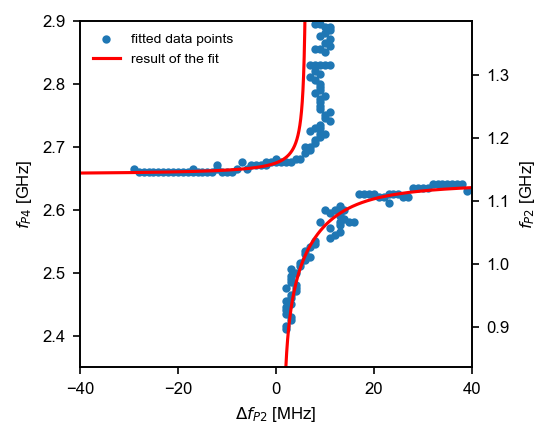

In [29]:
#manually dropping the data points

x_fit_all=[]
y_fit_all=[]

dfp2_fit_10_u=[]
dfp2_fit_10_d=[]
fp4_fit_10_u=[]
fp4_fit_10_d=[]

fig, ax = plt.subplots()
ax2=ax.twinx()

for i in range(0,len(x_fit)):
    if (y_fit[i]>2.4*10**9 and y_fit[i]<2.9*10**9) and (x_fit[i]>-30*10**6 and x_fit[i]<40*10**6): #we keep these points 
        if not(x_fit[i]>1.15*10**7 and y_fit[i]>2.7*10**9) and not(y_fit[i]>2.8*10**9 and x_fit[i]<0.7*10**7): #drop the points that come from another resonance 
            x_fit_all.append(x_fit[i])
            y_fit_all.append(y_fit[i])
            
            if y_fit[i]>2.635*10**9:
                dfp2_fit_10_u.append(x_fit[i])
                fp4_fit_10_u.append(y_fit[i])
            else:
                dfp2_fit_10_d.append(x_fit[i])
                fp4_fit_10_d.append(y_fit[i])
        
        
dfp2_fit_10_u=array(dfp2_fit_10_u)
dfp2_fit_10_d=array(dfp2_fit_10_d)
fp4_fit_10_u=array(fp4_fit_10_u)
dfp2_fit_10_d=array(dfp2_fit_10_d)

x_u, x_d, y_u, y_d = variables('x_u, x_d, y_u, y_d')

y0=Parameter('y0',2.663*10**9)   #fitting parameters with initial guesses 
A=Parameter('A',7.887126e+06)
chi3=Parameter('chi3',1.163172e+07)
#x0=Parameter('x0',0.2*10**7)
x0=0.15*10**7

fc=1.05*10**9
b=5.0*10**(-9)
fq1=1.5*10**9
#x0=0.1*10**7

def x_1(y_u,y0,A,chi3):  #theoretical curve without attenuation 
    return (x0*(y_u-y0)+pow(10,0*(y_u-fq1-fc))*(A*(x0+y_u-y0+A*pow(10,0*(y_u-fq1-fc)))-chi3**2))/(y_u-y0+A*10**(0*(y_u-fq1-fc)))

def x_2(y_d,y0,A,chi3):  #theoretical curve with attenuation 
    return (x0*(y_d-y0)+pow(10,b*(y_d-fq1-fc))*(A*(x0+y_d-y0+A*pow(10,b*(y_d-fq1-fc)))-chi3**2))/(y_d-y0+A*10**(b*(y_d-fq1-fc)))

model = Model({
    x_u: (x0*(y_u-y0)+pow(10,0*(y_u-fq1-fc))*(A*(x0+y_u-y0+A*pow(10,0*(y_u-fq1-fc)))-chi3**2))/(y_u-y0+A*10**(0*(y_u-fq1-fc))),
    x_d:(x0*(y_d-y0)+pow(10,b*(y_d-fq1-fc))*(A*(x0+y_d-y0+A*pow(10,b*(y_d-fq1-fc)))-chi3**2))/(y_d-y0+A*10**(b*(y_d-fq1-fc))) ,
})
fit = Fit(model, x_u=dfp2_fit_10_u, x_d=dfp2_fit_10_d, y_u=fp4_fit_10_u, y_d=fp4_fit_10_d)
fit_result = fit.execute()
print(fit_result)

A_10=fit_result.params["A"]
chi3_10=fit_result.params["chi3"]
y0_10=fit_result.params["y0"]
x0_10=x0

chi3=1.091477e+07  #result of the fit 
y0=2.660330e+09
A=4.907393e+06
#x0=3.979741e+06

chi3_10=chi3

x_fit_all=array(x_fit_all)
y_fit_all=array(y_fit_all)

ax.scatter(x_fit_all*10**(-6),y_fit_all*10**(-9),marker='.',label='fitted data points') #plot the fitted data points 

y1=linspace(2.657*10**9,2.9*10**9,5000)
y2=linspace(2.35*10**9,2.64*10**9,5000)

ax.plot(x_1(y1,y0,A,chi3)*10**(-6),y1*10**(-9),color='red',label='result of the fit') #plot the result of the fit 
ax.plot(x_2(y2,y0,A,chi3)*10**(-6),y2*10**(-9),color='red')

ax.set_ylim(2.35,2.9)
ax.set_xlim(-40,40)
ax2.set_ylim(2.35-1.514,2.9-1.514)

ax.set_xlabel(r'$\Delta f_{P2}$ [MHz]')
ax2.set_ylabel(r'$f_{P2}$ [GHz]')
ax.set_ylabel(r'$f_{P4}$ [GHz]')
ax.legend()

Text(0, 0.5, '$f_{P4}$ [GHz]')

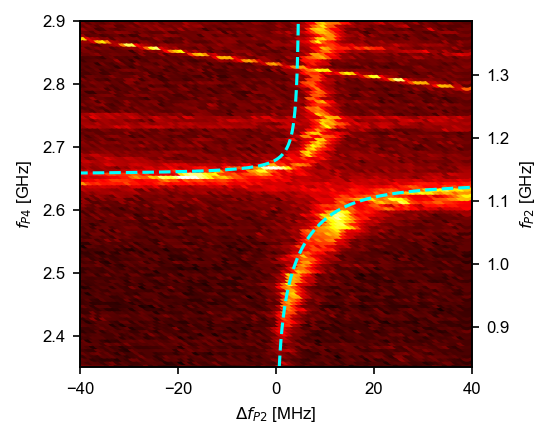

In [30]:
dfp2_10r = np.reshape(dfp2_10,(80, 300))
fp4_10r = np.reshape(fp4_10,(80, 300))
p_10r = np.reshape(p_10,(80, 300))

fig, ax = plt.subplots()
ax2=ax.twinx()
xlim(-40,40)

y1=linspace(2.657*10**9,2.9*10**9,5000)
y2=linspace(2.35*10**9,2.64*10**9,5000)

chi3=1.091477e+07  #result of the fit 
y0=2.660330e+09
A=4.907393e+06
x0=0.15*10**6

rbf = scipy.interpolate.Rbf(dfp2_10r*10**(-6), fp4_10r*10**(-9), p_10r, function='linear')

zi = rbf(dfp2_10r*10**(-6), fp4_10r*10**(-9))

ax.plot(x_1(y1,y0,A,chi3)*10**(-6),y1*10**(-9),linestyle='dashed',color='cyan') #plot the result of the fit 
ax.plot(x_2(y2,y0,A,chi3)*10**(-6),y2*10**(-9),linestyle='dashed',color='cyan')

ax.imshow(zi, vmin=p_10r.min(), vmax=p_10r.max(), origin='lower',aspect='auto',
           extent=[dfp2_10r.min()*10**(-6), dfp2_10r.max()*10**(-6), fp4_10r.min()*10**(-9), fp4_10r.max()*10**(-9)])

ax.scatter(dfp2_10r*10**(-6), fp4_10r*10**(-9), c=p_10r,cmap='hot') #plot the colormap 


ax.set_ylim(2.35,2.9)
ax.set_xlim(-40,40)
ax2.set_ylim(2.35-1.514,2.9-1.514)

ax.set_xlabel(r'$\Delta f_{P2}$ [MHz]')
ax2.set_ylabel(r'$f_{P2}$ [GHz]')
ax.set_ylabel(r'$f_{P4}$ [GHz]')

## (-9,9) detuning point

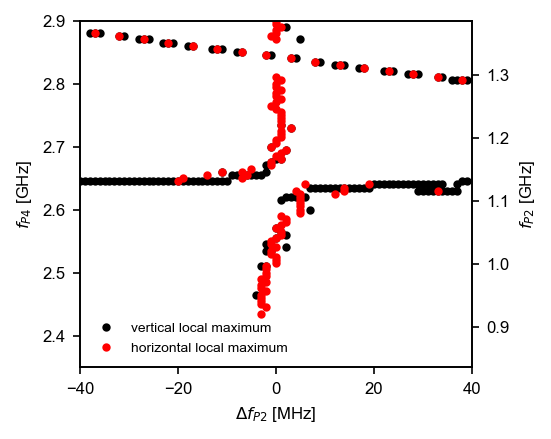

In [31]:
x=dfp2_9
y=fp4_9
z=p_9

fig, ax = plt.subplots()
ax2=ax.twinx()

xr=np.reshape(x,(300, 80))
yr=np.reshape(y,(300, 80))
zr=np.reshape(z,(300, 80))

x_fit=[]
y_fit=[]

x_fit1=[]
x_fit2=[]
y_fit1=[]
y_fit2=[]

for i in range(0,80):
    peaks, _ = find_peaks(zr[:,i],height=0.3,width=1,distance=1,prominence=0.15) #find the vertical peaks 
    for j in peaks:
        #scatter(xr[j,i],yr[j,i],marker='.',color='black')
        x_fit1.append(xr[j,i])
        y_fit1.append(yr[j,i])
        
for i in range(0,300):
    peaks, _ = find_peaks(zr[i,:],height=0.3,width=1,distance=1,prominence=0.15) #find the horizontal peaks 
    for j in peaks:
        #scatter(xr[i,j],yr[i,j],marker='.',color='red')
        x_fit2.append(xr[i,j])
        y_fit2.append(yr[i,j])

x_fit=merge_lists(x_fit1,x_fit2,y_fit1,y_fit2)[0] #merge the horizontal and vertical points 
y_fit=merge_lists(x_fit1,x_fit2,y_fit1,y_fit2)[1]

x_fit1=array(x_fit1)
x_fit2=array(x_fit2)
y_fit1=array(y_fit1)
y_fit2=array(y_fit2)

ax.plot(x_fit1*10**(-6),y_fit1*10**(-9),linestyle='',marker='.',color='black',label='vertical local maximum') #plot the points
ax.plot(x_fit2*10**(-6),y_fit2*10**(-9),linestyle='',marker='.',color='red',label='horizontal local maximum')
        
ax.set_ylim(2.35,2.9)
ax.set_xlim(-40,40)
ax2.set_ylim(2.35-1.514,2.9-1.514)

ax.set_xlabel(r'$\Delta f_{P2}$ [MHz]')
ax2.set_ylabel(r'$f_{P2}$ [GHz]')
ax.set_ylabel(r'$f_{P4}$ [GHz]')
ax.legend()


Parameter Value        Standard Deviation
A         2.605956e+06 2.608819e+05
chi3      5.669362e+06 3.131277e+05
y0        2.650365e+09 5.785104e+05
Status message         Desired error not necessarily achieved due to precision loss.
Number of iterations   32
Objective              <symfit.core.objectives.LeastSquares object at 0x0000021D6AFD0BE0>
Minimizer              <symfit.core.minimizers.BFGS object at 0x0000021D6AFD0D00>

Goodness of fit qualifiers:
chi_squared            1133359741367791.5
objective_value        566679870683895.8
r_squared              0.721065826395348


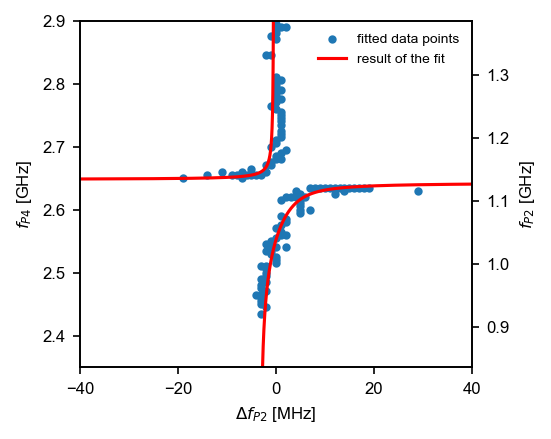

In [32]:
fig, ax = plt.subplots()
ax2=ax.twinx()

dfp2_fit_9_u=[]  #this contains the upper part 
dfp2_fit_9_d=[]  #this contains the lower part 
fp4_fit_9_u=[]
fp4_fit_9_d=[]

x_fit_all=[]
y_fit_all=[]


for i in range(0,len(x_fit)):   
    if y_fit[i]>2.4*10**9 and y_fit[i]<2.9*10**9 and x_fit[i]<30*10**6 and x_fit[i]>-30*10**6: #we keep this range of points
        if not(y_fit[i]>2.7*10**9 and x_fit[i]>0.2*10**7) and not(y_fit[i]>2.7*10**9 and x_fit[i]<-0.3*10**7): #we drop the ones that come from another resonance 
            if y_fit[i]>2.646*10**9 and x_fit[i]<1*10**7:
                dfp2_fit_9_u.append(x_fit[i])
                fp4_fit_9_u.append(y_fit[i])
            
                x_fit_all.append(x_fit[i])
                y_fit_all.append(y_fit[i])
            if y_fit[i]<2.64*10**9:
                dfp2_fit_9_d.append(x_fit[i])
                fp4_fit_9_d.append(y_fit[i])
            
                x_fit_all.append(x_fit[i])
                y_fit_all.append(y_fit[i])

x_fit_all=array(x_fit_all)
y_fit_all=array(y_fit_all)
ax.scatter(x_fit_all*10**(-6),y_fit_all*10**(-9),marker='.',label='fitted data points') #plot the fitted data points 

dfp2_fit_9_u=array(dfp2_fit_9_u)
dfp2_fit_9_d=array(dfp2_fit_9_d)
fp4_fit_9_u=array(fp4_fit_9_u)
dfp2_fit_9_d=array(dfp2_fit_9_d)

x_u, x_d, y_u, y_d = variables('x_u, x_d, y_u, y_d')

#x0=Parameter('x0',-3*10**7)
y0=Parameter('y0',2.648677e+09)    #fitting parameters with initial guesses 
A=Parameter('A',4.565372e+06)
chi3=Parameter('chi3',7.262695e+06)
#x0=Parameter('x0',-0.4*10**7)
x0=-0.5*10**7
x0=-0.3*10**7

fc=1.05*10**9
b=5.0*10**(-9)
fq1=1.5*10**9
#x0=0.1*10**7

def x_1(y_u,y0,A,chi3): #theoretical curve without attenuation 
    return (x0*(y_u-y0)+pow(10,0*(y_u-fq1-fc))*(A*(x0+y_u-y0+A*pow(10,0*(y_u-fq1-fc)))-chi3**2))/(y_u-y0+A*10**(0*(y_u-fq1-fc)))

def x_2(y_d,y0,A,chi3): #theoretical curve with attenuation 
    return (x0*(y_d-y0)+pow(10,b*(y_d-fq1-fc))*(A*(x0+y_d-y0+A*pow(10,b*(y_d-fq1-fc)))-chi3**2))/(y_d-y0+A*10**(b*(y_d-fq1-fc)))

model = Model({
    x_u: (x0*(y_u-y0)+pow(10,0*(y_u-fq1-fc))*(A*(x0+y_u-y0+A*pow(10,0*(y_u-fq1-fc)))-chi3**2))/(y_u-y0+A*10**(0*(y_u-fq1-fc))),
    x_d:(x0*(y_d-y0)+pow(10,b*(y_d-fq1-fc))*(A*(x0+y_d-y0+A*pow(10,b*(y_d-fq1-fc)))-chi3**2))/(y_d-y0+A*10**(b*(y_d-fq1-fc))) ,
})
fit = Fit(model, x_u=dfp2_fit_9_u, x_d=dfp2_fit_9_d, y_u=fp4_fit_9_u, y_d=fp4_fit_9_d) #fitting 
fit_result = fit.execute()
print(fit_result)

A_9=fit_result.params["A"]
chi3_9=fit_result.params["chi3"]
y0_9=fit_result.params["y0"]
x0_9=x0

chi3=5.669362e+06  #result of the fit 
y0=2.650365e+09
A=2.605956e+06
#x0=-1.453490e+06

chi3_9=chi3

y1=linspace(2.648*10**9,2.9*10**9,5000)
y2=linspace(2.35*10**9,2.642*10**9,5000)

ax.plot(x_1(y1,y0,A,chi3)*10**(-6),y1*10**(-9),color='red',label='result of the fit') #plot the result of the fit 
ax.plot(x_2(y2,y0,A,chi3)*10**(-6),y2*10**(-9),color='red')

ax.set_ylim(2.35,2.9)
ax.set_xlim(-40,40)
ax2.set_ylim(2.35-1.514,2.9-1.514)

ax.set_xlabel(r'$\Delta f_{P2}$ [MHz]')
ax2.set_ylabel(r'$f_{P2}$ [GHz]')
ax.set_ylabel(r'$f_{P4}$ [GHz]')
ax.legend()

Text(0, 0.5, '$f_{P4}$ [GHz]')

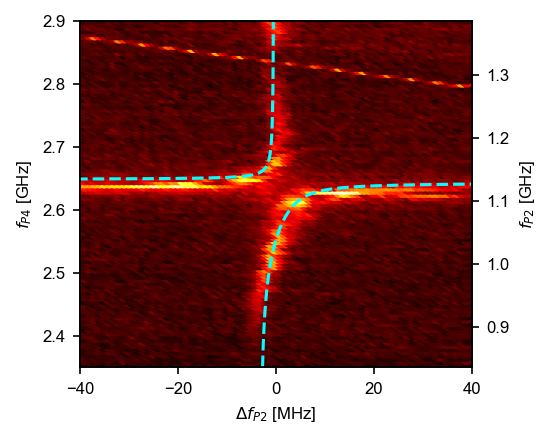

In [33]:
dfp2_9r = np.reshape(dfp2_9,(80, 300))
fp4_9r = np.reshape(fp4_9,(80, 300))
p_9r = np.reshape(p_9,(80, 300))

fig, ax = plt.subplots()
ax2=ax.twinx()

y1=linspace(2.648*10**9,2.9*10**9,5000)
y2=linspace(2.35*10**9,2.642*10**9,5000)

chi3=5.669362e+06  #result of the fit 
y0=2.650365e+09
A=2.605956e+06
#x0=-1.453490e+06

rbf = scipy.interpolate.Rbf(dfp2_9r*10**(-6), fp4_9r*10**(-9), p_9r, function='linear')

zi = rbf(dfp2_9r*10**(-6), fp4_9r*10**(-9))



ax.plot(x_1(y1,y0,A,chi3)*10**(-6),y1*10**(-9),linestyle='dashed',color='cyan')
ax.plot(x_2(y2,y0,A,chi3)*10**(-6),y2*10**(-9),linestyle='dashed',color='cyan')

ax.imshow(zi, vmin=p_9r.min(), vmax=p_9r.max(), origin='lower',aspect='auto',
           extent=[dfp2_9r.min()*10**(-6), dfp2_9r.max()*10**(-6), fp4_9r.min()*10**(-9), fp4_9r.max()*10**(-9)])

ax.scatter(dfp2_9r*10**(-6), fp4_9r*10**(-9), c=p_9r,cmap='hot')


ax.set_ylim(2.35,2.9)
ax.set_xlim(-40,40)
ax2.set_ylim(2.35-1.514,2.9-1.514)

ax.set_xlabel(r'$\Delta f_{P2}$ [MHz]')
ax2.set_ylabel(r'$f_{P2}$ [GHz]')
ax.set_ylabel(r'$f_{P4}$ [GHz]')

## (-8,8) detuning point

The problem with this anticrossing is that the asymptotic parts of the upper and lower part can have the same $f_{P4}$ value, they "overlap". The theoretical curve cannot overlap, so the fitting can be problematic. That is why we drop the asymptotic points, which have the same $f_{P4}$ value. This is also why the result of this fitting is less reliable. Leaving out the points which are far from the center of the anticrossing is unreasonable, the theoretical curve of the anticrossings is an approximation, which is better near the center of the anticrossings. 

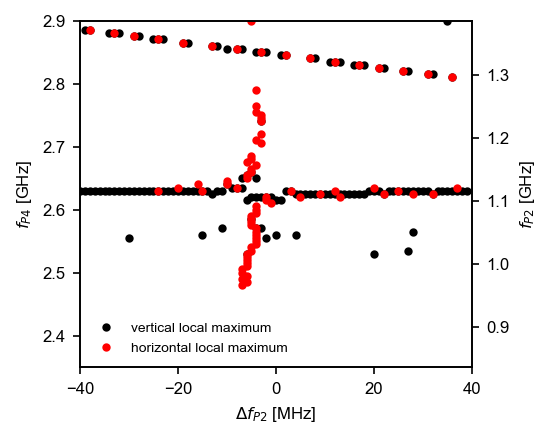

In [34]:
x=dfp2_8
y=fp4_8
z=p_8

fig, ax = plt.subplots()
ax2=ax.twinx()

xr=np.reshape(x,(300, 80))
yr=np.reshape(y,(300, 80))
zr=np.reshape(z,(300, 80))

x_fit=[]
y_fit=[]

x_fit1=[]
x_fit2=[]
y_fit1=[]
y_fit2=[]


for i in range(0,80):
    peaks, _ = find_peaks(zr[:,i],height=0.1,width=1,distance=2,prominence=0.12) #find the vertical peaks 
    for j in peaks:
        #scatter(xr[j,i],yr[j,i],marker='.',color='black')
        x_fit1.append(xr[j,i])
        y_fit1.append(yr[j,i])
        
for i in range(0,300):
    peaks, _ = find_peaks(zr[i,:],height=0.1,width=1,distance=2,prominence=0.12) #find the horizontal peaks 
    for j in peaks:
        #scatter(xr[i,j],yr[i,j],marker='.',color='red')
        x_fit2.append(xr[i,j])
        y_fit2.append(yr[i,j])
        
x_fit=merge_lists(x_fit1,x_fit2,y_fit1,y_fit2)[0]  #merge the vertical and the horizontal peaks 
y_fit=merge_lists(x_fit1,x_fit2,y_fit1,y_fit2)[1]

x_fit1=array(x_fit1)
x_fit2=array(x_fit2)
y_fit1=array(y_fit1)
y_fit2=array(y_fit2)

ax.plot(x_fit1*10**(-6),y_fit1*10**(-9),linestyle='',marker='.',color='black',label='vertical local maximum') #plot the points
ax.plot(x_fit2*10**(-6),y_fit2*10**(-9),linestyle='',marker='.',color='red',label='horizontal local maximum')
        
ax.set_ylim(2.35,2.9)
ax.set_xlim(-40,40)
ax2.set_ylim(2.35-1.514,2.9-1.514)

ax.set_xlabel(r'$\Delta f_{P2}$ [MHz]')
ax2.set_ylabel(r'$f_{P2}$ [GHz]')
ax.set_ylabel(r'$f_{P4}$ [GHz]')
ax.legend()


Parameter Value        Standard Deviation
A         9.425154e+05 4.775418e+05
chi3      5.362999e+06 1.361976e+06
y0        2.631533e+09 2.524439e+06
Status message         Desired error not necessarily achieved due to precision loss.
Number of iterations   15
Objective              <symfit.core.objectives.LeastSquares object at 0x0000021D6B386910>
Minimizer              <symfit.core.minimizers.BFGS object at 0x0000021D6B3869D0>

Goodness of fit qualifiers:
chi_squared            260823064865183.34
objective_value        130411532432591.67
r_squared              0.41725533329081665


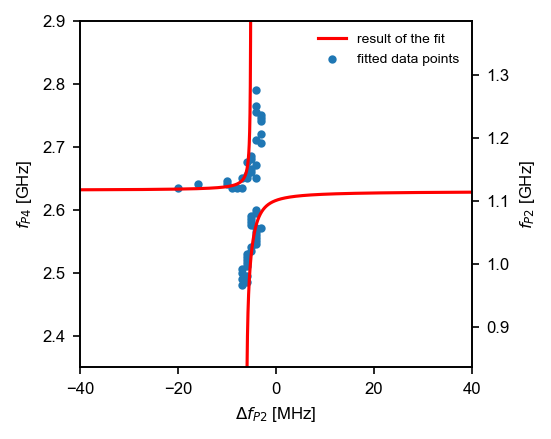

In [35]:
#manually drop the points which correspond to another resonance

x_fit_all=[]
y_fit_all=[]

fig, ax = plt.subplots()
ax2=ax.twinx()

dfp2_fit_8_u=[] #this will contain the upper part 
dfp2_fit_8_d=[] #this will contain the lower part 
fp4_fit_8_u=[]
fp4_fit_8_d=[]

for i in range(0,len(x_fit)):
    if y_fit[i]>2.3*10**9 and y_fit[i]<2.8*10**9 and x_fit[i]>-30*10**6 and x_fit[i]<15*10**6 and not(y_fit[i]<2.635*10**9 and y_fit[i]>2.62*10**9):
        if not(y_fit[i]<2.64*10**9 and x_fit[i]>-0.3*10**7) and not(y_fit[i]<2.62*10**9 and x_fit[i]<-0.7*10**7) and not(x_fit[i]>-0.7*10**7 and x_fit[i]<-0.2*10**7 and y_fit[i]<2.63*10**9 and y_fit[i]>2.60*10**9):
            x_fit_all.append(x_fit[i])  #we dropped the noise and the asymptotic points which cause the fitting problem 
            y_fit_all.append(y_fit[i])
            if x_fit[i]<0 and y_fit[i]>2.62*10**9:
                dfp2_fit_8_u.append(x_fit[i])
                fp4_fit_8_u.append(y_fit[i])
            else:
                dfp2_fit_8_d.append(x_fit[i])
                fp4_fit_8_d.append(y_fit[i])

dfp2_fit_8_u=array(dfp2_fit_8_u)
dfp2_fit_8_d=array(dfp2_fit_8_d)
fp4_fit_8_u=array(fp4_fit_8_u)
dfp2_fit_8_d=array(dfp2_fit_8_d)

x_u, x_d, y_u, y_d = variables('x_u, x_d, y_u, y_d')

#x0=Parameter('x0',-3*10**7)
y0=Parameter('y0',2.631672e+09)    #fitting parameters with initial guesses 
A=Parameter('A',4.587239e+06)
chi3=Parameter('chi3',5.950929e+06)
#x0=Parameter('x0',-0.4*10**7)
x0=-0.8*10**7
x0=-0.6*10**7

fc=1.05*10**9
b=5.0*10**(-9)
fq1=1.5*10**9
#x0=0.1*10**7

def x_1(y_u,y0,A,chi3):  #theoretical curve without attenuation 
    return (x0*(y_u-y0)+pow(10,0*(y_u-fq1-fc))*(A*(x0+y_u-y0+A*pow(10,0*(y_u-fq1-fc)))-chi3**2))/(y_u-y0+A*10**(0*(y_u-fq1-fc)))

def x_2(y_d,y0,A,chi3):  #theoretical curve with attenuation 
    return (x0*(y_d-y0)+pow(10,b*(y_d-fq1-fc))*(A*(x0+y_d-y0+A*pow(10,b*(y_d-fq1-fc)))-chi3**2))/(y_d-y0+A*10**(b*(y_d-fq1-fc)))

model = Model({
    x_u: (x0*(y_u-y0)+pow(10,0*(y_u-fq1-fc))*(A*(x0+y_u-y0+A*pow(10,0*(y_u-fq1-fc)))-chi3**2))/(y_u-y0+A*10**(0*(y_u-fq1-fc))),
    x_d:(x0*(y_d-y0)+pow(10,b*(y_d-fq1-fc))*(A*(x0+y_d-y0+A*pow(10,b*(y_d-fq1-fc)))-chi3**2))/(y_d-y0+A*10**(b*(y_d-fq1-fc))) ,
})
fit = Fit(model, x_u=dfp2_fit_8_u, x_d=dfp2_fit_8_d, y_u=fp4_fit_8_u, y_d=fp4_fit_8_d)  #fitting 
fit_result = fit.execute()
print(fit_result)

A_8=fit_result.params["A"]
chi3_8=fit_result.params["chi3"]
y0_8=fit_result.params["y0"]
x0_8=x0

chi3=5.362999e+06   #result of the fit 
y0=2.631533e+09
A=9.425154e+05
#x0=-1.453490e+06

chi3_8=chi3

y1=linspace(2.6313*10**9,2.9*10**9,5000)
y2=linspace(2.35*10**9,2.629*10**9,5000)

ax.plot(x_1(y1,y0,A,chi3)*10**(-6),y1*10**(-9),color='red',label='result of the fit')  #plot the result of the fit 
ax.plot(x_2(y2,y0,A,chi3)*10**(-6),y2*10**(-9),color='red')
              
x_fit_all=array(x_fit_all)
y_fit_all=array(y_fit_all)
ax.scatter(x_fit_all*10**(-6),y_fit_all*10**(-9),marker='.',label='fitted data points') #plot the fitted data points 
 
ax.set_ylim(2.35,2.9)
ax.set_xlim(-40,40)
ax2.set_ylim(2.35-1.514,2.9-1.514)

ax.set_xlabel(r'$\Delta f_{P2}$ [MHz]')
ax2.set_ylabel(r'$f_{P2}$ [GHz]')
ax.set_ylabel(r'$f_{P4}$ [GHz]')
ax.legend()

Text(0, 0.5, '$f_{P4}$ [GHz]')

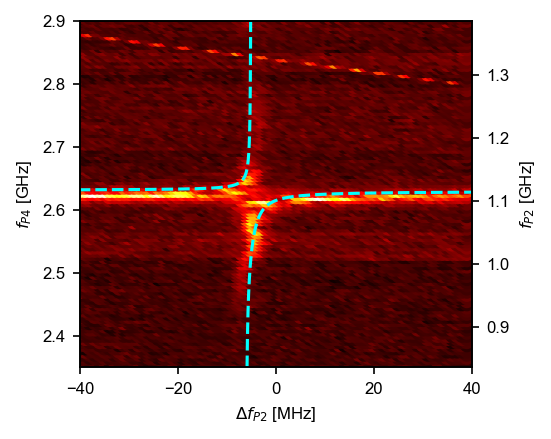

In [36]:
dfp2_8r = np.reshape(dfp2_8,(80, 300))
fp4_8r = np.reshape(fp4_8,(80, 300))
p_8r = np.reshape(p_8,(80, 300))

fig, ax = plt.subplots()
ax2=ax.twinx()

y1=linspace(2.6313*10**9,2.9*10**9,5000)
y2=linspace(2.35*10**9,2.629*10**9,5000)

chi3=5.362999e+06   #result of the fit 
y0=2.631533e+09
A=9.425154e+05
rbf = scipy.interpolate.Rbf(dfp2_8r*10**(-6), fp4_8r*10**(-9), p_8r, function='linear')

zi = rbf(dfp2_8r*10**(-6), fp4_8r*10**(-9))



ax.plot(x_1(y1,y0,A,chi3)*10**(-6),y1*10**(-9),linestyle='dashed',color='cyan') #plot the result of the fit 
ax.plot(x_2(y2,y0,A,chi3)*10**(-6),y2*10**(-9),linestyle='dashed',color='cyan')

ax.imshow(zi, vmin=p_8r.min(), vmax=p_8r.max(), origin='lower',aspect='auto',
           extent=[dfp2_8r.min()*10**(-6), dfp2_8r.max()*10**(-6), fp4_8r.min()*10**(-9), fp4_8r.max()*10**(-9)])

ax.scatter(dfp2_8r*10**(-6), fp4_8r*10**(-9), c=p_8r,cmap='hot') #plot the colormap 


ax.set_ylim(2.35,2.9)
ax.set_xlim(-40,40)
ax2.set_ylim(2.35-1.514,2.9-1.514)

ax.set_xlabel(r'$\Delta f_{P2}$ [MHz]')
ax2.set_ylabel(r'$f_{P2}$ [GHz]')
ax.set_ylabel(r'$f_{P4}$ [GHz]')

## (-7,7) detuning point

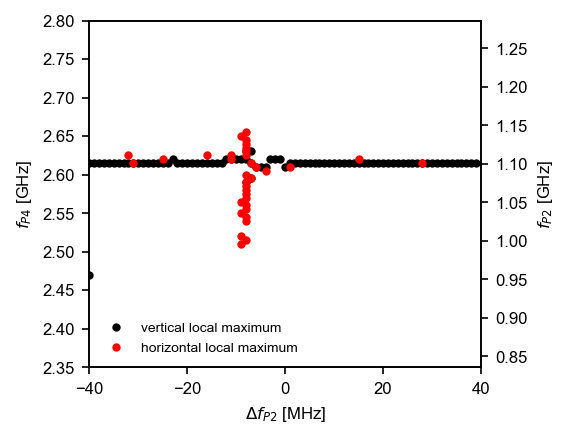

In [37]:
x=dfp2_7
y=fp4_7
z=p_7

fig, ax = plt.subplots()
ax2=ax.twinx()

xr=np.reshape(x,(300, 80))
yr=np.reshape(y,(300, 80))
zr=np.reshape(z,(300, 80))

x_fit=[]
y_fit=[]

x_fit1=[]
x_fit2=[]
y_fit1=[]
y_fit2=[]


for i in range(0,80):
    peaks, _ = find_peaks(zr[:,i],height=0.1,width=1,distance=2,prominence=0.12)  #find the vertical peaks 
    for j in peaks:
        #scatter(xr[j,i],yr[j,i],marker='.',color='black')
        x_fit1.append(xr[j,i])
        y_fit1.append(yr[j,i])
        
for i in range(0,300):
    peaks, _ = find_peaks(zr[i,:],height=0.1,width=1,distance=2,prominence=0.12)  #find the horizontal peaks 
    for j in peaks:
        #scatter(xr[i,j],yr[i,j],marker='.',color='red')
        x_fit2.append(xr[i,j])
        y_fit2.append(yr[i,j])
        
x_fit=merge_lists(x_fit1,x_fit2,y_fit1,y_fit2)[0]  #merge the vertical and horizontal peaks 
y_fit=merge_lists(x_fit1,x_fit2,y_fit1,y_fit2)[1]

x_fit1=array(x_fit1)
x_fit2=array(x_fit2)
y_fit1=array(y_fit1)
y_fit2=array(y_fit2)

ax.plot(x_fit1*10**(-6),y_fit1*10**(-9),linestyle='',marker='.',color='black',label='vertical local maximum') #plot the points
ax.plot(x_fit2*10**(-6),y_fit2*10**(-9),linestyle='',marker='.',color='red',label='horizontal local maximum')
        
ax.set_ylim(2.35,2.8)
ax.set_xlim(-40,40)
ax2.set_ylim(2.35-1.514,2.8-1.514)

ax.set_xlabel(r'$\Delta f_{P2}$ [MHz]')
ax2.set_ylabel(r'$f_{P2}$ [GHz]')
ax.set_ylabel(r'$f_{P4}$ [GHz]')
ax.legend()


Parameter Value        Standard Deviation
A         1.835672e+06 4.294038e+05
chi3      2.039367e+06 3.605306e+05
y0        2.616049e+09 7.651815e+05
Status message         Desired error not necessarily achieved due to precision loss.
Number of iterations   25
Objective              <symfit.core.objectives.LeastSquares object at 0x0000021D6B6BF3D0>
Minimizer              <symfit.core.minimizers.BFGS object at 0x0000021D6B6BF370>

Goodness of fit qualifiers:
chi_squared            51031194570410.31
objective_value        25515597285205.156
r_squared              0.6425761192757113


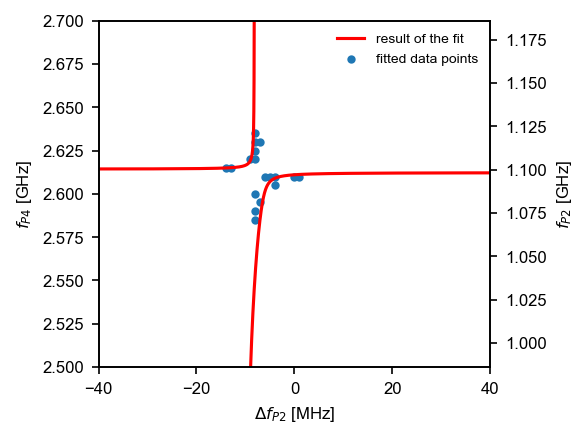

In [38]:
#manually drop the data points which are coming from another resonance 
x_fit_all=[]
y_fit_all=[]

fig, ax = plt.subplots()
ax2=ax.twinx()

dfp2_fit_7_u=[]
dfp2_fit_7_d=[]
fp4_fit_7_u=[]
fp4_fit_7_d=[]

for i in range(0,len(x_fit)):
    if y_fit[i]>2.58*10**9 and y_fit[i]<2.64*10**9 and x_fit[i]>-15*10**6 and x_fit[i]<3*10**6: #keep only this range of points
        if not(x_fit[i]>-0.8*10**7 and x_fit[i]<0.3*10**7 and y_fit[i]>2.61*10**9 and y_fit[i]<2.62*10**9):  #drop the points coming from noise 
            if not(y_fit[i]>2.615*10**9 and x_fit[i]>-0.7*10**7) and not(x_fit[i]<-0.9*10**7 and y_fit[i]>2.617*10**9):
                x_fit_all.append(x_fit[i])
                y_fit_all.append(y_fit[i])
                if x_fit[i]<-0.6*10**7 and y_fit[i]>2.614*10**9:
                    dfp2_fit_7_u.append(x_fit[i])
                    fp4_fit_7_u.append(y_fit[i])
                else:
                    dfp2_fit_7_d.append(x_fit[i])
                    fp4_fit_7_d.append(y_fit[i])                    

dfp2_fit_7_u=array(dfp2_fit_7_u)
dfp2_fit_7_d=array(dfp2_fit_7_d)
fp4_fit_7_u=array(fp4_fit_7_u)
dfp2_fit_7_d=array(dfp2_fit_7_d)

x_u, x_d, y_u, y_d = variables('x_u, x_d, y_u, y_d')

#x0=Parameter('x0',-3*10**7)
y0=Parameter('y0',2.611672e+09)   #fitting parameters with initial guesses 
A=Parameter('A',0.58e+06)
chi3=Parameter('chi3',1.60337e+06)
x0=-1.0*10**7

fc=1.05*10**9
b=5.0*10**(-9)
fq1=1.5*10**9
#x0=0.1*10**7

def x_1(y_u,y0,A,chi3):  #theoretical curve without attenuation 
    return (x0*(y_u-y0)+pow(10,0*(y_u-fq1-fc))*(A*(x0+y_u-y0+A*pow(10,0*(y_u-fq1-fc)))-chi3**2))/(y_u-y0+A*10**(0*(y_u-fq1-fc)))
 
def x_2(y_d,y0,A,chi3):  #theoretical curve with attenuation 
    return (x0*(y_d-y0)+pow(10,b*(y_d-fq1-fc))*(A*(x0+y_d-y0+A*pow(10,b*(y_d-fq1-fc)))-chi3**2))/(y_d-y0+A*10**(b*(y_d-fq1-fc)))

model = Model({
    x_u: (x0*(y_u-y0)+pow(10,0*(y_u-fq1-fc))*(A*(x0+y_u-y0+A*pow(10,0*(y_u-fq1-fc)))-chi3**2))/(y_u-y0+A*10**(0*(y_u-fq1-fc))),
    x_d:(x0*(y_d-y0)+pow(10,b*(y_d-fq1-fc))*(A*(x0+y_d-y0+A*pow(10,b*(y_d-fq1-fc)))-chi3**2))/(y_d-y0+A*10**(b*(y_d-fq1-fc))) ,
})
fit = Fit(model, x_u=dfp2_fit_7_u, x_d=dfp2_fit_7_d, y_u=fp4_fit_7_u, y_d=fp4_fit_7_d)
fit_result = fit.execute()
print(fit_result)

A_7=fit_result.params["A"]
chi3_7=fit_result.params["chi3"]
y0_7=fit_result.params["y0"]
x0_7=x0

chi3=2.039367e+06  #result of the fit 
y0=2.616049e+09
A=1.835672e+06
#x0=-1.453490e+06

chi3_7=chi3

y1=linspace(2.6143*10**9,2.9*10**9,5000)
y2=linspace(2.35*10**9,2.6122*10**9,5000)

ax.plot(x_1(y1,y0,A,chi3)*10**(-6),y1*10**(-9),color='red',label='result of the fit') #plot the result of the fit 
ax.plot(x_2(y2,y0,A,chi3)*10**(-6),y2*10**(-9),color='red')
               
x_fit_all=array(x_fit_all)
y_fit_all=array(y_fit_all)
ax.scatter(x_fit_all*10**(-6),y_fit_all*10**(-9),marker='.',label='fitted data points') #plot the fitted data points 

ax.set_ylim(2.5,2.7)
ax.set_xlim(-40,40)
ax2.set_ylim(2.5-1.514,2.7-1.514)

ax.set_xlabel(r'$\Delta f_{P2}$ [MHz]')
ax2.set_ylabel(r'$f_{P2}$ [GHz]')
ax.set_ylabel(r'$f_{P4}$ [GHz]')
ax.legend()

Text(0, 0.5, '$f_{P4}$ [GHz]')

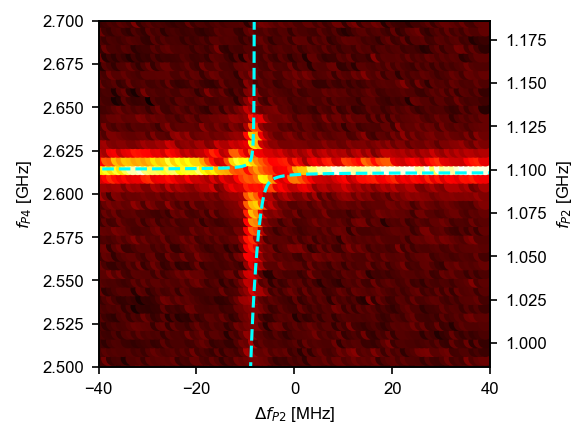

In [39]:
dfp2_7r = np.reshape(dfp2_7,(80, 300))
fp4_7r = np.reshape(fp4_7,(80, 300))
p_7r = np.reshape(p_7,(80, 300))

fig, ax = plt.subplots()
ax2=ax.twinx()
xlim(-40,40)

y1=linspace(2.6143*10**9,2.9*10**9,5000)
y2=linspace(2.35*10**9,2.6122*10**9,5000)

chi3=2.039367e+06
y0=2.616049e+09
A=1.835672e+06

rbf = scipy.interpolate.Rbf(dfp2_7r*10**(-6), fp4_7r*10**(-9), p_7r, function='linear')

zi = rbf(dfp2_7r*10**(-6), fp4_7r*10**(-9))

ax.plot(x_1(y1,y0,A,chi3)*10**(-6),y1*10**(-9),linestyle='dashed',color='cyan') #plot the result of the fitting 
ax.plot(x_2(y2,y0,A,chi3)*10**(-6),y2*10**(-9),linestyle='dashed',color='cyan')

ax.imshow(zi, vmin=p_7r.min(), vmax=p_7r.max(), origin='lower',aspect='auto',
           extent=[dfp2_7r.min()*10**(-6), dfp2_7r.max()*10**(-6), fp4_7r.min()*10**(-9), fp4_7r.max()*10**(-9)])

ax.scatter(dfp2_7r*10**(-6), fp4_7r*10**(-9), c=p_7r,cmap='hot') #plot the colormap 


ax.set_ylim(2.5,2.7)
ax.set_xlim(-40,40)
ax2.set_ylim(2.5-1.514,2.7-1.514)

ax.set_xlabel(r'$\Delta f_{P2}$ [MHz]')
ax2.set_ylabel(r'$f_{P2}$ [GHz]')
ax.set_ylabel(r'$f_{P4}$ [GHz]')

# Power attenuation

In [40]:
beta=1.231-0.446                   #difference of virtual plunger matrix elements
aU_ratio=0.03583*10**(-3) #1/ueV   #leverarm divided by Coulomb-energy U 
alfa=(0.0903+0.0931)/2       #leverarm 
U=alfa/aU_ratio #ueV
print(U)

def EP2(f):                       #frequency in GHz, EP2 in ueV, result of the fitting of the power attenuation 
    cucc=1.36+7.28*e**(-0.45*f)
    return cucc*beta*1000 
print(alfa)

2559.3078425900085
0.0917


# Calculating the hopping parameters

In [41]:
fq1=1.514  #resonance frequencies at (-10,10) mV point
fq1b=1.570
fq2=2.655
fq2b=2.714

def MHz_to_ueV(chi3):
    cucc=chi3*4.13566553853809*10**(-3)
    return cucc

Gamma=MHz_to_ueV(-1000*gamma)
dGamma=MHz_to_ueV(-1000*dgamma)

print(Gamma)

def chi3_t2(chi3,f):  #chi3 MHz, f GHz, calculates the t and parameter from the chi3 and the frequency of the transition, if that is proportional to t^2 
    chi3=MHz_to_ueV(chi3)
    #print(chi3)
    vP=10000 #ueV
    t2=chi3*U*(1-4*aU_ratio**2*vP**2)**2/(4*EP2(f)*vP*aU_ratio**2) #this is t^2 
    O2=t2-U*Gamma #from the fit of the spectrum, this is \Omega^2 
    t=sqrt(t2)
    O=sqrt(O2)
    return [t,O]

def chi3_tO(chi3,f):  #chi3 MHz, f GHz, calculates t and \Omega parameters from the chi3 and the frequency, if the chi3 is proportial to t*Omega 
    chi3=MHz_to_ueV(chi3)
    #print(chi3)
    vP=10000 #ueV
    Ot=U*chi3*(1-4*aU_ratio**2*vP**2)**2/(4*EP2(f)*vP*aU_ratio**2)
    #print(Ot)
    t=sqrt((Gamma*U+sqrt((Gamma*U)**2+4*Ot**2))/2)
    O=Ot/t
    valami=(t**2-O**2)/U

    return [t,O]

def ratio(VP1,chi3):
    return chi3*(1*(1-aU**2*(2*VP1)**2)**2)/(2*beta*Ep2*2*VP1*aU**2)

0.04738937662903365


In [42]:
t_AC1=chi3_t2(chi3_AC1*10**(-6),fq2-fq1)[0] #we calculate the hopping parameters from every fitted anticrossing
O_AC1=chi3_t2(chi3_AC1*10**(-6),fq2-fq1)[1]

t_AC5=chi3_t2(chi3_AC5*10**(-6),fq2-fq1)[0]
O_AC5=chi3_t2(chi3_AC5*10**(-6),fq2-fq1)[1]

t_AC3=chi3_tO(chi3_AC3*10**(-6),fq1b)[0]
O_AC3=chi3_tO(chi3_AC3*10**(-6),fq1b)[1]

t_AC4=chi3_tO(chi3_AC4*10**(-6),fq1b)[0]
O_AC4=chi3_tO(chi3_AC4*10**(-6),fq1b)[1]

print('AC1 t and O: ',t_AC1, O_AC1) #print the result, in ueV 
print('AC5 t and O: ',t_AC5,O_AC5)
print('AC3 t and O: ',t_AC3,O_AC3)
print('AC4 t and O: ',t_AC4,O_AC4)

AC1 t and O:  14.321903355815829 9.15603148046091
AC5 t and O:  13.83068299538582 8.366826689774145
AC3 t and O:  13.86517735505967 8.423724818933842
AC4 t and O:  13.696502147764415 8.143105539140318


# Fitting the different detunings

[0.04854598]
[0.00219771]
11.146483905788845 1.720494173158473


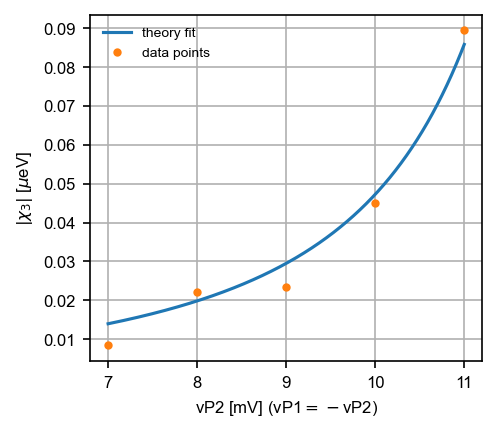

In [43]:
fig, ax = plt.subplots()

chi3=[2.039367,5.362999,5.669362,10.91477,21.63016] #MHz  #chi3 parameters at different detunings 

chi3=array(chi3)
chi3=MHz_to_ueV(chi3)   #convert Mhz to ueV 

def ki3(VP1,ratio):    #theoretical function for chi3 parameter 
    f=fq2-fq1
    return 2*EP2(f)*2*VP1*ratio*aU_ratio**2/(1*(1-aU_ratio**2*(2*VP1)**2)**2)

VP1=1000*linspace(7,11,5)  #detuning points in mV 
VP2=-VP1

popt,pcov=curve_fit(ki3,VP1,chi3,p0=[0.05])  #fit the data points 
perr=sqrt(diag(pcov))

VP=1000*linspace(7,11,5000)

ax.plot(VP/1000,ki3(VP,popt[0]),label='theory fit')
ax.plot(VP1/1000,chi3,linestyle='',marker='.',label='data points')  #plot the result 

ax.set_xlabel(r'vP2 [mV] (vP1$=-$vP2)')
ax.set_ylabel(r'$|\chi_3|$ [$\mu$eV]')
legend()
grid(True)

print(popt)
print(perr)

t_detuning=sqrt(popt[0]*U)             #from the fit calculate t hopping 
O_detuning=sqrt(t_detuning**2-U*Gamma) #calculate Omega hopping from the fit 
print(t_detuning,O_detuning)           #print the result in ueV 

fig.savefig('anticrossing-detuning-fit.png', format='png', dpi=300,bbox_inches="tight")
fig.savefig('anticrossing-detuning-fit.pdf', format='pdf', dpi=300,bbox_inches="tight")

### Calculating average hopping parameters

From the four fitted anticrossings, and the detuning dependence of one of the anticrossings we could calculate five $t$ hopping values. We will take the average of the hopping, calculate a numerical standard deviation, and using the average t we calculate an average $\Omega$ parameter. We will use the two average parameters to calculate Rabi frequencies and plot theoretical resonance lines. 

In [44]:
t=array([t_AC1,t_AC5,t_AC3,t_AC4,t_detuning]) #t values from the fits 

t_avg=t.mean()
dt_avg=t.std()
O_avg2=t_avg**2-U*Gamma   #we can calculate the average Omega parameter from the fit of the spectrun 
O_avg=sqrt(O_avg2)

dO_avg=sqrt((t_avg/sqrt(t_avg**2-U*Gamma)*dt_avg)**2+(1/(2*sqrt(t_avg**2-U*Gamma))*U*dGamma)**2) #the uncertainty of Omega 

print('Average t: ',t_avg,dt_avg)    #print the results in ueV 
print('Average Omega:',O_avg,dO_avg)


Average t:  13.372149951962916 1.1326211896533254
Average Omega: 7.584879107516766 2.124703848386344


# Calculating monochromatic and bichromatic frequencies

In [45]:
beta2=1.231-0.446
beta4=0.353-0.234

def ep2(f): #frequency in GHz, EP2 in ueV, this function calculates the electric field of P2 
    cucc=1.36+7.28*e**(-0.45*f)
    return cucc*beta2*1000*alfa

def ep4(f): #frequency in GHz, EP2 in ueV, this function calculates the electric field of P4
    cucc=1.36+7.28*e**(-0.45*f)
    return cucc*beta4*1000*alfa 

def ueV_to_MHz(x):  #convert ueV to MHz 
    return x*241799.0504*1000*10**(-6)

## $Q2^{P2}$

In [46]:
eps=alfa*20000

error=dO_avg/O_avg+dt_avg/t_avg  #relative error of the frequencies 

f_Q2P2=4*ep2(fq2)*eps*U*O_avg*t_avg/(U**2-eps**2)**2  #calculate the frequency 
#print(f_Q2P2)
f_Q2P2=ueV_to_MHz(f_Q2P2)
df_Q2P2=f_Q2P2*error
print(f_Q2P2,df_Q2P2)  #print the result and uncertainty in MHz 

11.634929112795279 4.244697119744695


## $Q2\_^{P2}$

In [47]:
f_Q2bP2=4*ep2(fq2b)*eps*U*O_avg*t_avg/(U**2-eps**2)**2 #calculate the frequency 
f_Q2bP2=ueV_to_MHz(f_Q2bP2)
df_Q2bP2=f_Q2bP2*error
print(f_Q2bP2,df_Q2bP2)  #print the result and the uncertainty in MHz 

11.446404791808558 4.175918991873325


## $Q1^{P4}$

In [48]:
f_Q1P4=4*ep4(fq1)*eps*U*O_avg*t_avg/(U**2-eps**2)**2  #calculate the frequency 
f_Q1P4=ueV_to_MHz(f_Q1P4)
df_Q1P4=f_Q1P4*error
print(f_Q1P4,df_Q1P4)  #print the result and the uncertainty in MHz 

2.495722704041179 0.9104986262335669


## $Q1\_^{P4}$

In [49]:
f_Q1bP4=4*ep4(fq1b)*eps*U*O_avg*t_avg/(U**2-eps**2)**2 #calculate the frequency 
f_Q1bP4=ueV_to_MHz(f_Q1bP4)
df_Q1bP4=f_Q1bP4*error
print(f_Q1bP4,df_Q1bP4)  #print the result and the uncertainty in MHz 

2.4503639525942154 0.893950681699001


## $Q1^{-P2,P4}$

In [50]:
fp4=3.45     #this is the frequency of plunger P4 
fp2=fp4-fq1  #frequency of plunger P2 

f_Q1P4mP2=2*ep2(fp2)*ep4(fp4)*U*(U**2+3*eps**2)*O_avg*t_avg/(U**2-eps**2)**3  #calculate frequency 
f_Q1P4mP2=ueV_to_MHz(f_Q1P4mP2)
df_Q1P4mP2=f_Q1P4mP2*error

print(f_Q1P4mP2,df_Q1P4mP2)  #print the result and the uncertainty in MHz 

0.6483525473093176 0.23653433239369492


## $Q2^{-P2,P4}$

In [51]:
fp4=4.2
fp2=fp4-fq2

f_Q2P4mP2=2*ep2(fp2)*ep4(fp4)*U*(U**2+3*eps**2)*O_avg*t_avg/(U**2-eps**2)**3  #calculate the frequency 
f_Q2P4mP2=ueV_to_MHz(f_Q2P4mP2)
df_Q2P4mP2=f_Q2P4mP2*error

print(f_Q2P4mP2,df_Q2P4mP2)  #print the result and the uncertainty in MHz 

0.6227993507063709 0.22721192234982843


## $Q2^{P2,P4}$

In [52]:
fp4=1.2      #frequency of plunger P4 in GHz 
fp2=fq2-fp4  #frequnecy of plunger P2 in GHz 

f_Q2P4P2=2*ep2(fp2)*ep4(fp4)*U*(U**2+3*eps**2)*O_avg*t_avg/(U**2-eps**2)**3  #calculate the frequency
f_Q2P4P2=ueV_to_MHz(f_Q2P4P2)
df_Q2P4P2=f_Q2P4P2*error

print(f_Q2P4P2,df_Q2P4P2)  #plot the frequency and the uncertainty in MHz 

1.4611342272992027 0.5330562985000667


# Figure2

loaded 1 files
loaded 1 files
loaded 1 files
loaded 1 files
loaded 1 files
[1, 2, 'Ot', 2]
[[0, 1]]


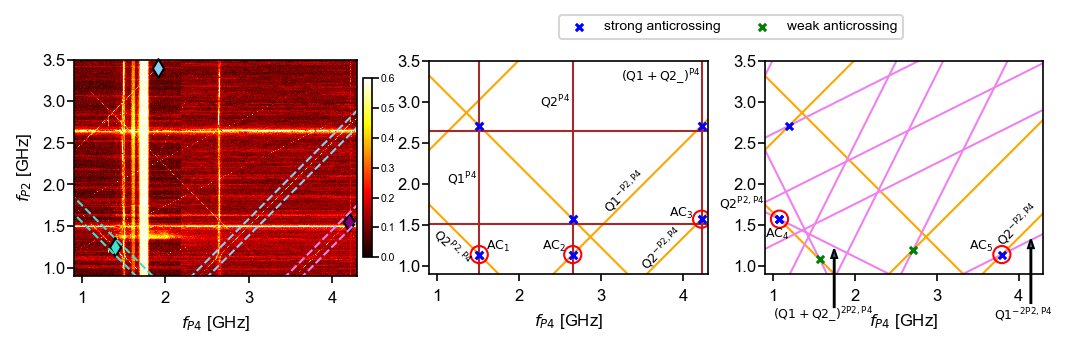

In [53]:
import sys
import os
from utils.notebook_tools import get_data_from
from matplotlib.ticker import FormatStrFormatter
import pickle
from matplotlib.ticker import MaxNLocator

plt.rcParams['figure.constrained_layout.use'] = False
plt.rcParams['legend.fontsize']= 'small'
plt.rcParams['legend.scatterpoints']= 1
plt.rcParams['axes.labelpad'] = 4 #-2
plt.rcParams['legend.frameon']= True

script_dir = os.path.dirname() #<-- absolute dir the script is in
sys.path.append(script_dir)
save_path = os.path.join(script_dir, 'Figures')

start_time = '2022-07-12\\17-59-02'

end_time = start_time #'2021-06-24\\18-03-01' #'2021-06-10\\18-32-47'
datadir = os.path.join(script_dir, 'measurements')
datfiles, fnames = get_data_from(start_time, end_time, num = 1, rootfolder=datadir, only_complete = False) 
datfile = datfiles[0]

start_time2 = '2022-07-13\\17-27-20'

end_time2 = start_time2 #'2021-06-24\\18-03-01' #'2021-06-10\\18-32-47'
datfiles2, fnames2 = get_data_from(start_time2, end_time2, num = 1, rootfolder=datadir, only_complete = False) 
datfile2 = datfiles2[0]

start_time_rabi_q1dif = '2022-07-13\\15-56-21' # '2022-07-13\\15-26-45' # 
start_time_rabi_q2dif = '2022-07-13\\14-27-14'
start_time_rabi_q2sum = '2022-07-13\\14-51-17'

start_time_rabi_list = [start_time_rabi_q1dif, start_time_rabi_q2dif, start_time_rabi_q2sum]
mixing_regime = ['difference', 'difference', 'sum']
fp4_fp2 = [(2.6, 1.10064), (4.2, 1.5539), (1.4, 1.2472)]

datfile_rabi = {}

for start_time_rabi in start_time_rabi_list:
    end_time = start_time_rabi #'2021-06-24\\18-03-01' #'2021-06-10\\18-32-47'
    datfiles, fnames = get_data_from(start_time_rabi, end_time, num = 1, rootfolder=datadir, only_complete = False) 
    datfile_rabi[start_time_rabi] = datfiles

    
#%% Calibrated Rabi frequencies
with open(os.path.join(script_dir, 'measurements\config_freq_rabi.txt'), "rb") as file:
    config_freq_rabi = pickle.load(file)

vP1 = -10
vP2 = 10
P2_pwr = -5
P4_pwr = 3

try:
    fq2p2 = config_freq_rabi['P2'][P2_pwr]['fq2'][(vP1,vP2)]
    fq2 = fq2p2/1e9
    fq2_p2 = config_freq_rabi['P2'][P2_pwr]['fq2_'][(vP1,vP2)]
    fq2_ = fq2_p2/1e9
    fq1p4 = config_freq_rabi['P4'][P4_pwr]['fq1'][(vP1,vP2)]
    fq1 = fq1p4/1e9
except:
    print('Could not find calibrated data in database')
    fq1 = 1.51e9/1e9
    fq2 = 2.66e9/1e9

mixing_regime = 'difference'
fq = fq1
#%% Plotting
figure_size = 'small'

#figsize = {'big':(1.0*fig_size_double,1.0*fig_size_double/3), 'small':(1.0*fig_size_double ,1.0*fig_size_double/3)}

P2_frequency = datfile.sig_gen3_frequency_set.ndarray/1e9
P4_frequency = datfile.sig_gen2_frequency_set.ndarray[0,:]/1e9
P2_frequency2 = datfile2.sig_gen3_frequency_set.ndarray/1e9
P4_frequency2 = datfile2.sig_gen2_frequency_set.ndarray[0,:]/1e9

linestyles = ['-', ':', '--', '-.']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


#fig = plt.figure(figsize=(1.35*fig_size_double, 1.3*fig_size_double/3))
fig = plt.figure(figsize=(1.05*fig_size_double, 0.8*1.05*fig_size_double/3))
#originally 1.05 

gs1 = GridSpec(nrows=1, ncols=3,width_ratios=[1.07,1,1],hspace=0.3)


ax1 = fig.add_subplot(gs1[0,0])
ax2 = fig.add_subplot(gs1[0,1])
ax3= fig.add_subplot(gs1[0,2])


vmin = 0
vmax = 0.6
cm = ax1.pcolor(P4_frequency, P2_frequency, datfile.su0-datfile.su0.min(), shading='auto', cmap='hot', zorder=1, vmin=vmin, vmax=vmax)
ax1.pcolor(P4_frequency2, P2_frequency2[0:-90], datfile2.su0[0:-90]-datfile2.su0[0:-90].min(), shading='auto', cmap='hot', zorder=1, vmin=vmin, vmax=vmax)

ax1.set_ylabel(r'$f_{P2}$ [GHz]',fontsize=8)
ax1.set_xlabel(r'$f_{P4}$ [GHz]',fontsize=8)

ax1.set_ylim(bottom=0)
ax1.set_xlim(left=0)

ymin, ymax = ax1.get_ylim()
xmin, xmax = ax1.get_xlim()
ymax = 4.3e9
xmax = 4.3e9
lw = 1

if figure_size == 'big':
    show_1tone = True
    show_2tone_dif = True
    show_2tone_sum = True
    show_2tone_harmonic = True
else:
    show_1tone = True
    show_2tone_dif = True
    show_2tone_sum = True
    show_2tone_harmonic = False

if show_1tone:
    ax1.hlines(fq1, xmin, xmax, lw = lw, ls=linestyles[0], color='black', label = 'fq1 = fp4 or fq1 = fp2', zorder=0)
    ax1.hlines(fq2, xmin, xmax, lw = lw, ls=linestyles[0], color='navy', label = 'fq2 = fp4 or fq2 = fp2', zorder=0)
    
    ax1.vlines(fq1, ymin, ymax, lw = lw, ls=linestyles[0], color='black', zorder=0)
    ax1.vlines(fq2, ymin, ymax, lw = lw, ls=linestyles[0], color='navy', zorder=0)
    
    ax1.vlines(fq2/2, ymin, ymax, lw = lw, ls=linestyles[1], color='navy', label = 'fq2/2 = fp2', zorder=0)


if show_2tone_dif:
    # differences
    ax1.plot([fq1,xmax],[0,xmax-fq1], lw = lw, ls=linestyles[2], color=colors[0], label = 'fq1 = |fp4 - fp2|', zorder=0)
    ax1.plot([fq2,xmax],[0,xmax-fq2], lw = lw, ls=linestyles[2], color=colors[1], label = 'fq2 = |fp4 - fp2|', zorder=0)
    
    ax1.plot([0,ymax-fq1], [fq1,ymax], lw = lw, ls=linestyles[2], color=colors[0], zorder=0)
    ax1.plot([0,ymax-fq2], [fq2,ymax], lw = lw, ls=linestyles[2], color=colors[1], zorder=0)


if show_2tone_sum:
    # sum
    # ax1.plot([0,fq1], [fq1,0], lw = lw, ls=linestyles[2], color=colors[2], label = 'fq1 = fp4 + fp2', zorder=0)
    ax1.plot([0,fq1+fq2_], [fq1+fq2_,0], lw = lw, ls=linestyles[1], color=colors[2], label = 'fq1 + fq2 = fp4 + fp2', zorder=0)
    ax1.plot([0,fq2], [fq2,0], lw = lw, ls=linestyles[2], color=colors[2], label = 'fq2 = fp4 + fp2', zorder=0)


if show_2tone_harmonic:
    ax1.plot([0,2*fq1],[fq1/2,5/2*fq1], lw = lw, ls=linestyles[1], color=colors[5], label = 'fq1 = 2*(fp4 - fp2)', zorder=0)
    
    ax1.plot([0,fq1],[fq1/2,fq1], lw = lw, ls=linestyles[3], color=colors[3], label = 'fq1 = 2*fp4 + fp2', zorder=0)
    ax1.plot([0,4*fq1],[-fq1/2,3/2*fq1], lw = lw, ls=linestyles[3], color=colors[3], label = 'fq1 = -2*fp4 + fp2', zorder=0)
      
    ax1.plot([0,fq1],[-fq1,fq1], lw = lw, ls=linestyles[2], color=colors[3], label = 'fq1 = 2*fp2 + fp4', zorder=0)
    
    ax1.plot([0,fq2],[(fq1+fq2)/2,(fq1+2*fq2)/2], lw = lw, ls=linestyles[1], color=colors[5], label = 'fq1 + fq2 = 2*fp4 + fp2', zorder=0)
    
    ax1.plot([0,fq1],[fq1/3,2/3*fq1], lw = lw, ls=linestyles[1], color=colors[3], label = 'fq1 = 3*fp4 + fp2', zorder=0)
    
    # ax1.plot([0,2*fq1],[fq1/4,5/4*fq1], lw = lw, ls=linestyles[3], color=colors[3], label = 'fq1 = 2*fp4 + fp2', zorder=0)
    
    ax1.plot([0,fq2],[fq2/2,fq2], lw = lw, ls=linestyles[3], color=colors[4], label = 'fq2 = 2*fp4 + fp2', zorder=0)
    ax1.plot([0,fq2],[-fq2,fq2], lw = lw, ls=linestyles[2], color=colors[4], label = 'fq2 = 2*fp2 + fp4', zorder=0)
    

colors = ['lightskyblue', 'purple', 'turquoise']
n = 0
for start_time_rabi in start_time_rabi_list:
    fp4 = np.round(datfile_rabi[start_time_rabi][0].metadata['station']['instruments']['sig_gen2']['parameters']['frequency']['value']/1e9, 3)
    fp2 = np.round(datfile_rabi[start_time_rabi][0].metadata['station']['instruments']['sig_gen3']['parameters']['frequency']['value']/1e9, 3)
    ax1.scatter([fp4],[fp2], s=40, zorder=1, marker='d', color=colors[n], edgecolors='black', clip_on=False)
    n = n + 1


ax1.axis('square')
ax1.set_ylim(0.9,3.5)
ax1.set_xlim(0.9,4.3)

ax1.plot([-100e-3,fq2-100e-3], [fq2,0], lw = 1, ls=linestyles[2], color='turquoise', zorder=2)
ax1.plot([+100e-3,fq2+100e-3], [fq2,0], lw = 1, ls=linestyles[2], color='turquoise', zorder=2)
ax1.plot([fq2-100e-3,2*fq2-100e-3], [0,fq2], lw = 1, ls=linestyles[2], color='violet', zorder=2)
ax1.plot([fq2+100e-3,2*fq2+100e-3], [0,fq2], lw = 1, ls=linestyles[2], color='violet', zorder=2)
ax1.plot([fq1-100e-3,4*fq1-100e-3], [0,3*fq1], lw = 1, ls=linestyles[2], color='lightskyblue', zorder=2)
ax1.plot([fq1+100e-3,4*fq1+100e-3], [0,3*fq1], lw = 1, ls=linestyles[2], color='lightskyblue', zorder=2)

cbar = fig.colorbar(cm, fraction=0.03, pad=0.02,ax=ax1)
cbar.ax.tick_params(labelsize=5,pad=0.5)
# cbar.set_label(r'$1-P_{\downdownarrows}$')

Q1=1.514  #transition frequencies
Q1b=1.570
Q2=2.655
Q2b=2.714

def mono(P,f):         #P is either 2 or 4, f can be Q1, Q2 or Q1+Q2b
    if P==2:  #if plunger P2 is used
        y=f  #the fp2 is constant 
        x0=0
        x=5
        ax2.plot([x0,x],[y,y],color='brown',linewidth=1)  #plots the monochromatic resonance line
        if f==Q1:
            char=r'$\mathrm{Q1^{P2}}$'
        if f==Q2:
            char=r'$\mathrm{Q2^{P2}}$'
        if f==Q1+Q2b:
            char=r'$\mathrm{(Q1+Q2\_)^{P2}}$'
        #if f==Q1+Q2b:
        #if f==Q1:
            #text(3.55,y+0.05,char)  #label of the transition
    else:       #if plunger P4 is used
        x=f
        y0=0
        y=5
        ax2.plot([x,x],[y0,y],color='brown',linewidth=1)
        if f==Q1:
            char=r'$\mathrm{Q1^{P4}}$'
        if f==Q2:
            char=r'$\mathrm{Q2^{P4}}$'
        if f==Q1+Q2b:
            char=r'$\mathrm{(Q1+Q2\_)^{P4}}$'
            
def fp2(C2,C4,f,x):
    return f/C2-x*C4/C2  #calculates the equation of the resonance line

def fp4(C2,C4,f,y):
    return f/C4-y*C2/C4

def bichro(C2,C4,i):   #c2*fp2+c4*fp4=Q_i, Q1, Q2 and Q1+Q2_ are the three frequencies
    if i==1:
        f=Q1
    if i==2:
        f=Q2
    if i==3:
        f=Q1+Q2b
    I=array([0,5])
    ax2.plot(I,fp2(C2,C4,f,I),color='orange',zorder=1,linewidth=1) #plot of the resonance line

    charP2='P2'
    charP4='P4'
    
    charQ='Q2'
    
    if i==1:
        charQ='Q1'
    if i==2:
        charQ='Q2'
    if i==3:
        charQ='(Q1+Q2\_)'
    if C2==1:
        charP2='P2'
    if C2==-1:
        charP2='-P2'
    if C4==1:
        charP4='P4'
    if C4==-1:
        charP4='-P4'
    
    char2='$\mathrm{'+charQ+'^'+'{'+charP2+','+charP4+'}}$'
    
            
def Q(i):    #function that returns the Q as a function of an index 
    q=0
    if i==1:
        q=Q1
    if i==2:
        q=Q2
    if i==3:
        q=Q1+Q2b
    return q

def intersection_mono_bi(mono,bi):    
    #mono has two elements, first is 2 or 4, which tells us if it is driven by P2 or P4, second is Qi
    #bihas three elements, C2, C4 and Qj
    x=0
    y=0
    Qi=Q(mono[1])
    Qj=Q(bi[2])
    C2=bi[0]
    C4=bi[1]
    if mono[0]==2:
        y=Qi
        x=(Qj-C2*y)/C4
    if mono[0]==4:
        x=Qi
        y=(Qj-C4*x)/C2
    return [x,y]   #intersection point of a monochromatic with a bichromatic 

import matplotlib.lines as mlines


def Q(i):    #function that returns the Q as a function of an index 
    q=0
    if i==1:
        q=Q1
    if i==2:
        q=Q2
    if i==3:
        q=Q1+Q2b
    return q

mono(2,Q1)      #plotting the monochromatic transitions
mono(2,Q2)
mono(2,Q1+Q2b)

mono(4,Q1)
mono(4,Q2)
mono(4,Q1+Q2b)

bichro(1,1,1)    #plotting the bichromatic transitions
bichro(1,1,2)
bichro(1,1,3)

bichro(-1,1,1)
bichro(-1,1,2)
bichro(-1,1,3)

bichro(1,-1,1)
bichro(1,-1,2)
bichro(1,-1,3)


mon4=[[0,1,1],[0,1,2],[0,1,3]]   #monochromatic transitions, C2*P2+C4*P4=Q_i, driven by P4 or P2
mon2=[[1,0,1],[1,0,2],[1,0,3]]

bikro=[[1,1,1],[1,1,2],[1,1,3],[1,-1,1],[1,-1,2],[1,-1,3],[-1,1,1],[-1,1,2],[-1,1,3]]  #similar to the monochromatic transitions

bichro_sum=[[1,1,1],[1,1,2],[1,1,3]]        #bichromatic, when the sum of the frequencies is resonant 
bichro_diff=[[1,-1,1],[1,-1,2],[1,-1,3],[-1,1,1],[-1,1,2],[-1,1,3]]   #bichromatic, when the difference is resonant 

#circles around the analysed anticrossings

x=(Q(2)-1*Q(1))/1    #intersection point of a monochromatic driven by P2 and a bichromatic 
y=Q(1)
ax2.scatter(y,x,s=68,marker='o',facecolors='none',edgecolors='red',zorder=2,) #draw circles around the analysed anticrossings

x=(Q(1)-1*Q(2))/(-1)    #intersection point of a monochromatic driven by P2 and a bichromatic 
y=Q(2)
ax2.scatter(y,x,s=68,marker='o',facecolors='none',edgecolors='red',zorder=2,)

x=(Q(2)-1*Q(3))/(-1)    #intersection point of a monochromatic driven by P2 and a bichromatic 
y=Q(3)
ax2.scatter(y,x,s=68,marker='o',facecolors='none',edgecolors='red',zorder=2,)

m=20*2/3 #markersize

for i in bichro_sum:       #intersection of a bichromatic with sum and a bichromatic with diff 
    for j in bichro_diff:
        C21=i[0]
        C41=i[1]
        Qi=Q(i[2])
        
        C22=j[0]
        C42=j[1]
        Qj=Q(j[2])
        
        x=(Qj-C22*Qi/C21)/(C42-C41*C22/C21)  #calculates the intersection point
        y=(Qj-C42*x)/C22
        #mlines.Line2D([x,x],[y,y],marker='*',color='green',linestyle='None',markersize=10)  

for j in mon4:
    for i in bikro:
        x=(Q(i[2])-i[0]*Q(j[2]))/i[1]   #intersection point of a monochromatic driven by P4 and a bichromatic 
        y=Q(j[2])
        #plot([x],[y],marker='x',color='black',markersize=4)
        #ax1.scatter(x,y,s=m,marker='x',color='black',zorder=2)
        
for j in mon2:
    for i in bikro:
        x=(Q(i[2])-i[1]*Q(j[2]))/i[0]     #intersection point of a monochromatic driven by P2 and a bichromatic 
        y=Q(j[2])
        if i[1]==1:
            #plot([y],[x],marker='x',color='red',markersize=4)
            ax2.scatter(y,x,s=m,marker='x',color='blue',zorder=2)
        #else:
            #plot([y],[x],marker='x',color='black',markersize=4)
        #    ax1.scatter(y,x,s=m,marker='x',color='black',zorder=2)

twophoton2=[1,2,3]
twophoton4=[1,2,3]

mon4=[1,2,3]
mon2=[1,2,3]
        
#putting legends 
#scatter(Q(1),Q(2),s=m,marker='x',color='black',zorder=2,label='crossing')       

x=(Q(3)-1*Q(1))/1    #intersection point of a monochromatic driven by P2 and a bichromatic 
y=Q(1)
#ax1.scatter(y,x,s=m,marker='x',color='blue',zorder=2,label='strong anticrossing, size$\sim$$\Omega t$')  #we put labels 

x=intersection_mono_bi([4,1],[1,1,2])[0]
y=intersection_mono_bi([4,1],[1,1,2])[1] 
#ax1.scatter(x,y,s=m,marker='x',color='purple',zorder=3,label='strong anticrossing, size$\sim$$t^2$')    #labels 

x=intersection_mono_bi([4,1],[1,-1,1])[0]
y=intersection_mono_bi([4,1],[1,-1,1])[1]
#ax1.scatter(x,y,s=m,marker='x',color='black',label='crossing',zorder=3)    #labels 

C21=-1
C41=1
Qi=Q(1)
        
C22=1
C42=1
Qj=Q(3)
        
x=(Qj-C22*Qi/C21)/(C42-C41*C22/C21)
y=(Qj-C42*x)/C22
#scatter(x,y,s=m,marker='x',color='green',zorder=2,label='weak anticrossing') #2nd order anticrossing, when just 
#two photon processes are competing 

ax2.set_xlabel(r'$f_{P4}$ [GHz]',fontsize=8)
#ax1.set_ylabel(r'$f_{P2}$ [GHz]')

ax2.text(1.12,2,r'$\mathrm{Q1^{P4}}$',fontsize=9*2/3)
ax2.text(0.9,1.0,r'$\mathrm{Q2^{P2,P4}}$',fontsize=9*2/3,rotation=-45)
ax2.text(2.25,2.95,r'$\mathrm{Q2^{P4}}$',fontsize=9*2/3)
ax2.text(3.0,1.65,r'$\mathrm{Q1^{-P2,P4}}$',fontsize=9*2/3,rotation=45)

ax2.text(3.25,3.25,r'$\mathrm{(Q1+Q2\_)^{P4}}$',fontsize=9*2/3)
ax2.text(3.45,0.95,r'$\mathrm{Q2^{-P2,P4}}$',fontsize=9*2/3,rotation=45)
#ax2.arrow(3.3, 1.16, 0.25, -0.08,
#          head_width = 0.07,
#          width = 0.01,
#          ec ='black')


def dominates(trans1,trans2): #decides if transition 1 dominates transition 2
    t=0          #t is a logical value, which tells us if trans1 dominates trans2
    
    a=trans1[0]  #a*fp2+b*fp4=Qi, similarly for c and d
    b=trans1[1]
    
    c=trans2[0]
    d=trans2[1]
    
    ph_nr1=abs(a)+abs(b)   #photon number of a process 
    ph_nr2=abs(c)+abs(d)
    
    if ph_nr1<ph_nr2:      #if it is a process, with less pohoton numbers, then it dominates 
        t=1
    
    if ph_nr1==ph_nr2:     #if it has the same number of photons, but contains more ep2, then it dominates
        if abs(a)>abs(c):
            t=1
    return t

def anticrossing(trans1,trans2):   #this function tells us if two transitions cross or not, it will give an answer only if the 
    C21=trans1[0]                  #two transition lines intersect at some point 
    C41=trans1[1]                  #trans1 has form [C21,C41,Qi], trans2 [C22,C42,Qj]
    Qi=trans1[2]
    
    anti=0        #if it is anticrossing 
    order=0       #the order of the anticrossing 
    hop=''        #if it is a 1st order anticrossing, then it tells us which hopping parameters are contributing 
    ep=0          #it is 2, if the 1st order anticrossing is mediated by ep2, it is 4, if it is mediated by ep4
    
    C22=trans2[0]
    C42=trans2[1]
    Qj=trans2[2]
    
    ph_nr1=abs(C21)+abs(C41)     #calculate photon numbers 
    ph_nr2=abs(C22)+abs(C42)
    
    ph_nr_diff=abs(C22-C21)+abs(C42-C41)  #and we also calculate photon number differences 
    
    if dominates([C22-C21,C42-C41],[C21,C41]) and dominates([C22-C21,C42-C41],[C22,C42]): #if the difference dominates both
        anti=1                                                                            #then it is an anticrossings
        order=ph_nr_diff                                                                  #order is the photon number difference
    if Qi==Qj:       #if both processes drive the same transition, then it is not an anticrossing
        anti=0
        order=0
    if order==1:             #if we have a 1st order anticrossing
        if abs(C22-C21)==1:  #if the ep2 photon number is 1, then it is mediated by ep2   
            ep=2
        if abs(C42-C41)==1:  #similarly to ep4
            ep=4
    if order==2:             #if the order is 2, then lets look at the photon number 
        if abs(C22-C21)==2:
            ep=2
        if abs(C42-C41)==2:
            ep=4
    if anti==1:              #this chooses the hopping parameters 
        if Qi!=Qj:
            if Qi+Qj==3:
                hop='t2'
            if Qi+Qj==4:
                hop='Ot'
            if Qi+Qj==5:
                hop='Ot'
    return [anti,order,hop,ep]    #return if it is anticrossing, the order, the hopping parameters and the ep2 or ep4

print(anticrossing([1,1,2],[-1,1,3]))

def intersection(trans1,trans2):  #calculates the intersection point of two transitions (both are at least bichromatic)
    C21=trans1[0]                 #trans1 has the form [C21,C41,Qi], trans2 [C22,C42,Qj], Qi 1,2 or 3
    C41=trans1[1]
    Qi=Q(trans1[2])               #we calculate the actual Qi value using the function Q()
    
    C22=trans2[0]
    C42=trans2[1]
    Qj=Q(trans2[2])
    
    x=(C22*Qi-C21*Qj)/(C41*C22-C42*C21)   #calculates the intersection points
    y=(C42*Qi-C41*Qj)/(C21*C42-C22*C41)
    return [x,y]

trikro_l=[[1,2],[2,1],[-1,2],[2,-1],[1,-2],[-2,1]]  #these are the trichromatic processes, without the specification of Qi
trikro_l=array(trikro_l)
trikro=[]
for i in trikro_l:
    for j in range(1,4):
        cucc=[]
        cucc=i
        cucc=append(cucc,j)
        #print(cucc)
        trikro.append(cucc)  #this adds the Qi term, so we will get 18 transitions, every element of trikro_l will have 3 
                             #different Qi values 

def bichro2(C2,C4,i):   #c2*fp2+c4*fp4=Q_i, Q1, Q2 and Q1+Q2_ are the three frequencies
    if i==1:            #just slightly redefine the function used before for bichromatic transitions 
        f=Q1
    if i==2:
        f=Q2
    if i==3:
        f=Q1+Q2b
    I=array([0,5])
    ax3.plot(I,fp2(C2,C4,f,I),color='orange',zorder=1,linewidth=1) #plot of the resonance line

    charP2='P2'
    charP4='P4'
    
    charQ='Q2'
    
    if i==1:
        charQ='Q1'
    if i==2:
        charQ='Q2'
    if i==3:
        charQ='(Q1+Q2\_)'
    if C2==1:
        charP2='P2'
    if C2==-1:
        charP2='-P2'
    if C4==1:
        charP4='P4'
    if C4==-1:
        charP4='-P4'
    
    char2='$\mathrm{'+charQ+'^'+'{'+charP2+','+charP4+'}}$'      
        
def trichro(line):  #line has the form [C2,C4,Qi], Qi has value 1,2 or 3
    C2=line[0]
    C4=line[1]
    Qi=Q(line[2])   #we calculate the actual Qi value
    
    I=array([0,5])  #the interval of plotting
    I=array([0,5])
    y=(Qi-C4*I)/C2  #y interval
    ax3.plot(I,y,color='violet',zorder=1,linewidth=1) #plot of the resonance line
    global kar  
    global kar1  #these are the strings that will give the label of the resonance line, kar1 the Q
    global kar2  #kar2 the P2
    global kar4  #kar4 the P4
    kar1=''
    kar2=''
    kar4=''
    if C2==-2*C4:
        if Qi==Q1:
            kar1=r'$\mathrm{Q1^'
        if Qi==Q2:
            kar1=r'$\mathrm{Q2^'
        if Qi==Q1+Q2b:
            kar1=r'$\mathrm{(Q1+Q2\_)^'
        if C2==2:
            kar2='{2P2,'
        if C2==-2:
            kar2='{-2P2,'
        if C4==1:
            kar4='P4}}$'
        if C4==-1:
            kar4='-P4}}$'
        kar=kar1+kar2+kar4
        #if y[1]>=1 and y[1]<=5: 
        #    text(5,y[1],kar)  #it also plots the label 
    
    if C4==-2*C2:
        if Qi==Q1:
            kar1=r'$\mathrm{Q1^'
        if Qi==Q2:
            kar1=r'$\mathrm{Q2^'
        if Qi==Q1+Q2b:
            kar1=r'$\mathrm{(Q1+Q2\_)^'
        if C2==1:
            kar2='{P2,'
        if C2==-1:
            kar2='{-P2,'
        if C4==2:
            kar4='2P4}}$'
        if C4==-2:
            kar4='-2P4}}$'
        kar=kar1+kar2+kar4
        X=(Qi-5*C2)/C4-0.1
        #if X>=1 and X<=5 and Qi==Q1+Q2b: 
    if C4==2*C2:
        if Qi==Q1:
            kar1=r'$\mathrm{Q1^'
        if Qi==Q2:
            kar1=r'$\mathrm{Q2^'
        if Qi==Q1+Q2b:
            kar1=r'$\mathrm{(Q1+Q2\_)^'
        if C2==1:
            kar2='{P2,'
        if C2==-1:
            kar2='{-P2,'
        if C4==2:
            kar4='2P4}}$'
        if C4==-2:
            kar4='-2P4}}$'
        kar=kar1+kar2+kar4
        Y=(Qi-C4*1)/C2
        #if Y>=1 and Y<=5: 
        #    if Qi!=Q1+Q2b:
        #        text(1,Y,kar,zorder=3)
        #    else:
        #        text(1-1.2,Y-0.07,kar,zorder=3)  #shifted to left
    
    if C2==2*C4:
        if Qi==Q1:
            kar1=r'$\mathrm{Q1^'
        if Qi==Q2:
            kar1=r'$\mathrm{Q2^'
        if Qi==Q1+Q2b:
            kar1=r'$\mathrm{(Q1+Q2\_)^'
        if C2==2:
            kar2='{2P2,'
        if C2==-2:
            kar2='{-2P2,'
        if C4==1:
            kar4='P4}}$'
        if C4==-1:
            kar4='-P4}}$'
        kar=kar1+kar2+kar4
        Y=(Qi-C4*1)/C2
        #if Y>=1 and Y<=5:
        #    if Qi!=Q1+Q2b:
        #        text(1,Y+0.07,kar,zorder=3)
        #    else:
        #        text(1.2,0.55,kar,zorder=3)  #label brought down
                

bichro2(1,1,1)    #plotting the bichromatic transitions
bichro2(1,1,2)
bichro2(1,1,3)

bichro2(-1,1,1)
bichro2(-1,1,2)
bichro2(-1,1,3)

bichro2(1,-1,1)
bichro2(1,-1,2)
bichro2(1,-1,3)

m=18*2/3 #markersize

for i in trikro:  #we plot all of the trichromatic transitions
    trichro(i)

bikro=[[1,1,1],[1,1,2],[1,1,3],[1,-1,1],[1,-1,2],[1,-1,3],[-1,1,1],[-1,1,2],[-1,1,3]]  #similar to the monochromatic transitions

#there are six different kind of resonance lines

bichro_sum=[[1,1,1],[1,1,2],[1,1,3]]        #bichromatic, when the sum of the frequencies is resonant 
bichro_diff=[[1,-1,1],[1,-1,2],[1,-1,3],[-1,1,1],[-1,1,2],[-1,1,3]]   #bichromatic, when the difference is resonant
trichro_big=[[1,-2,2],[1,-2,1],[-1,2,1],[-1,2,2],[-1,2,3]]   #trichromatic transitions with a slope of 2
trichro_small=[[2,-1,3],[2,-1,2],[2,-1,1],[-2,1,1],[-2,1,2]] #trichromatic transitions with a slope of 1/2
trichro_neg1=[[1,2,3]]                                #trichromatic transitions with a slope of -2
trichro_neg2=[[2,1,3]]                                #trichromatic transitions with a slope of -1/2

#lines=[bichro_sum,bichro_diff,trichro_big,trichro_small,trichro_neg1,trichro_neg2]  #all groups of transitions in a single list
lines=[bikro,trikro] #when we are interested only in the intersection of bicchromatic 2photon with bichro 3photon

#numbers=[0,1,2,3,4,5]                #using these numbers we generate all possible pairs of transition groups to intersect
numbers=[0,1]
pairs=[]                           #these are in the pairs 
for i in range(len(numbers)):
    for j in range(i+1, len(numbers)):
        pairs.append([numbers[i],numbers[j]])

print(pairs)

for i in pairs:
    set1=lines[i[0]]               #from the pairs we choose two sets of transitions
    set2=lines[i[1]]
    for j in set1:                 #we take two elements, intersect 
        for k in set2:
            anti=anticrossing(j,k)  #see if it is an anticrossing
            x=intersection(j,k)[0]  #calculate intersection points
            y=intersection(j,k)[1]
            
            #if anti[0]==0:
                #ax2.scatter(x,y,s=m,marker='x',color='black',zorder=2)  #it is a crossing
            if anti[0]==1:
                if anti[1]==2:
                    if anti[3]==2:
                        ax3.scatter(x,y,s=m,marker='x',color='green',zorder=2) #second order anticrossing driven by P2
                    if anti[3]==4:
                        ax3.scatter(x,y,s=m,marker='x',color='green',zorder=2) #second order anticrossing driven by P4 
                    if anti[3]==0:
                        ax3.scatter(x,y,s=m,marker='x',color='red',zorder=2) #second order anticrossing driven by P4 
                if anti[1]==1:             #first order anticrossing, driven by P2
                    if anti[3]==2:
                        if anti[2]=='Ot':
                            ax3.scatter(x,y,s=m,marker='x',color='blue',zorder=2)
                        if anti[2]=='t2':
                            ax3.scatter(x,y,s=m,marker='x',color='blue',zorder=2)
                    else:                  #first order anticrossing, driven by P4
                        if anti[2]=='Ot':
                            ax3.scatter(x,y,s=m,marker='x',color='green',zorder=2)
                        if anti[2]=='t2':
                            ax3.scatter(x,y,s=m,marker='x',color='green',zorder=2)                        
                    

x=intersection([2,1,3],[1,1,2])[0]   
y=intersection([2,1,3],[1,1,2])[1]
ax3.scatter(x,y,s=68,marker='o',facecolors='none',edgecolors='red',zorder=2) #draw circles around the analysed anticrossings

x=intersection([-1,1,2],[-2,1,1])[0]   
y=intersection([-1,1,2],[-2,1,1])[1]
ax3.scatter(x,y,s=68,marker='o',facecolors='none',edgecolors='red',zorder=2) #draw circles around the analysed anticrossings

x=intersection([-1,2,1],[1,-1,1])[0]   
y=intersection([-1,2,1],[1,-1,1])[1]
#ax2.scatter(x,y,s=m,marker='x',color='black',zorder=2,label='crossing') #draw circles around the analysed anticrossings

x=intersection([2,1,3],[1,1,2])[0]  
y=intersection([2,1,3],[1,1,2])[1]
ax3.scatter(x,y,s=m,marker='x',color='blue',zorder=2,label='strong anticrossing') 

x=intersection([-1,1,2],[-2,1,1])[0] 
y=intersection([-1,1,2],[-2,1,1])[1]
#ax2.scatter(x,y,s=m,marker='x',color='purple',zorder=2,label='strong anticrossing, size$\sim$$t^2$') 

x=intersection([1,-1,2],[1,-2,1])[0]  
y=intersection([1,-1,2],[1,-2,1])[1]
ax3.scatter(x,y,s=m,marker='x',color='green',zorder=2,label='weak anticrossing') 

ax3.set_xlabel(r'$f_{P4}$ [GHz]',fontsize=8)
#ax2.set_ylabel(r'$f_{P2}$ [GHz]')

ax3.arrow(1.75, 0.5, 0, 0.6,
          head_width = 0.07,
          width = 0.01,
          ec ='black',clip_on=False)

ax3.arrow(4.15, 0.55, 0, 0.67,
          head_width = 0.07,
          width = 0.01,
          ec ='black',clip_on=False)

ax3.text(1,0.35,r'$\mathrm{(Q1+Q2\_)^{2P2,P4}}$',fontsize=9*2/3)
ax3.text(0.35,1.7,r'$\mathrm{Q2^{P2,P4}}$',fontsize=9*2/3)
ax3.text(3.7,1.25,r'$\mathrm{Q2^{-P2,P4}}$',fontsize=9*2/3,rotation=45)
#ax2.text(3.7,0.87,r'$\mathrm{Q1^{-2P2,P4}}$',fontsize=9*2/3,rotation=26.565)
ax3.text(3.7,0.35,r'$\mathrm{Q1^{-2P2,P4}}$',fontsize=9*2/3,rotation=0)

ax2.axis('square')
ax3.axis('square')

ax2.set_ylim(0.9,3.5)
ax2.set_xlim(0.9,4.3)
ax3.set_ylim(0.9,3.5)
ax3.set_xlim(0.9,4.3)

legend(loc='upper center', bbox_to_anchor=(-0.12, 1.25),
          fancybox=True, shadow=False, ncol=2)

plt.subplots_adjust(left=0.05,
                    bottom=0.05,
                    right=0.97,
                    top=0.95,
                    hspace=0.4)

ax1.tick_params(axis='y', pad=0.5)
ax2.tick_params(axis='y', pad=0.5)
ax3.tick_params(axis='y', pad=0.5)

ax2.text(1.6,1.2,r'$\mathrm{AC_1}$',fontsize=9*2/3)
ax2.text(2.28,1.2,r'$\mathrm{AC_2}$',fontsize=9*2/3)
ax2.text(3.83,1.6,r'$\mathrm{AC_3}$',fontsize=9*2/3)

ax3.text(0.9,1.35,r'$\mathrm{AC_4}$',fontsize=9*2/3)
ax3.text(3.4,1.2,r'$\mathrm{AC_5}$',fontsize=9*2/3)

plt.savefig('Figure2.png',format='png', dpi=300,bbox_inches='tight')
plt.savefig('Figure2.pdf',format='pdf',dpi=300,bbox_inches='tight')
plt.savefig('Figure2.svg',format='svg',bbox_inches='tight')
plt.show()
#%%


# Figure3

In [54]:
muB=57.883818060*0.241799050402293  #Bohr magneton in GHz 
B=0.675                             #magnetic field in Tesla 
#g10=0.17439208                      #g-factor 
#c1=-0.00104254                        
#d=-0.01145871
#a=0.03582596

def get_fq1(VP1):   #this function calculates the frequency of qubit 1 at different detunings (VP2=-VP1)

    return (muB*B*(g10-c1*VP1)+2*d*1/(1-4*a**2*VP1**2))

def get_fq1b(VP1):  #this function calculates fQ1_ frequency at different detunings (VP2=-VP1)

    return (muB*B*(g10-c1*VP1)-2*d*1/(1-4*a**2*VP1**2))

def get_fq2(VP1):   #this function calculates the frequency of qubit 2 at different detunings (VP2=-VP1)

    return (muB*B*(g20+c2*VP1)+2*d*1/(1-4*a**2*VP1**2))

def get_fq2b(VP1):  #this function calculates fQ2_ frequency at different detunings (VP2=-VP1)

    return (muB*B*(g20+c2*VP1)-2*d*1/(1-4*a**2*VP1**2))

def EP2(f): #frequency in GHz, EP2 in ueV, calculates the electric field of plunger P2, without the lever arm  
    cucc=1.36+7.28*e**(-0.45*f)
    return cucc*beta*1000 

t_avg_eps=t_avg
O_avg_eps=O_avg

alpha=U*a*10**(-3)

C:/Users/betme/data
C:/Users/betme/data\measurements
loaded 1 files
loaded 1 files
loaded 1 files
loaded 1 files
loaded 1 files
loaded 1 files
[-40.0]
[39.0]
[-40.0, -40.0]
[39.0, 39.0]


C:\Users\betme\AppData\Local\Temp\ipykernel_15780\1768157875.py:270: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig1.tight_layout()


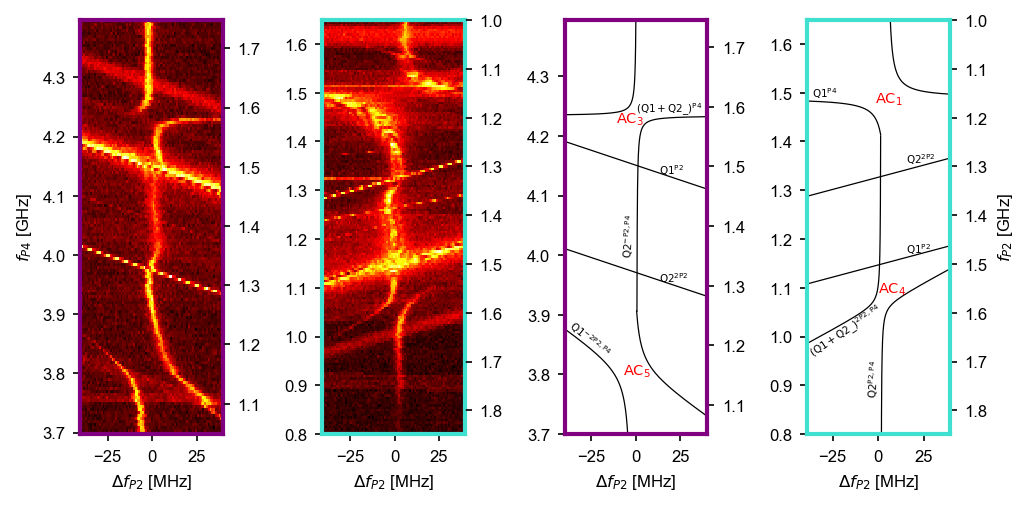

In [55]:
#%% path

script_dir = os.path.dirname() #<-- absolute dir the script is in
print(script_dir)
sys.path.append(script_dir)
save_path = os.path.join(script_dir, 'Figures')

#%% imports
#%% defining style
fig_size_single = 3.37
fig_size_double = 6.69

plt.rcParams['figure.dpi'] = 150
#%% load data
start_time_q1dif = '2022-07-11\\13-12-41'
start_time_q2dif = '2022-07-12\\14-28-39'
start_time_q2sum = '2022-07-12\\15-39-11'

start_time_list = [start_time_q1dif, start_time_q2dif, start_time_q2sum]
mixing_regime = ['difference', 'difference', 'sum']

datfile = {}

datadir = os.path.join(script_dir, 'measurements')
print(datadir)
for start_time in start_time_list:
    end_time = start_time #'2021-06-24\\18-03-01' #'2021-06-10\\18-32-47'    
    datfiles, fnames = get_data_from(start_time, end_time, num = 1, rootfolder=datadir, only_complete = False) 
    datfile[start_time] = datfiles[0]

start_time_rabi_q1dif = '2022-07-13\\15-26-45'
start_time_rabi_q2dif = '2022-07-13\\14-27-14'
start_time_rabi_q2sum = '2022-07-13\\14-51-17'

start_time_rabi_list = [start_time_rabi_q1dif, start_time_rabi_q2dif, start_time_rabi_q2sum]
mixing_regime = ['difference', 'difference', 'sum']
fp4_fp2 = [(2.6, 1.10064), (4.2, 1.5539), (1.4, 1.2472)]

datfile_rabi = {}

for start_time_rabi in start_time_rabi_list:
    end_time = start_time_rabi #'2021-06-24\\18-03-01' #'2021-06-10\\18-32-47'
    datfiles, fnames = get_data_from(start_time_rabi, end_time, num = 1, rootfolder=datadir, only_complete = False) 
    datfile_rabi[start_time_rabi] = datfiles


#%% Calibrated Rabi frequencies
with open(os.path.join(script_dir, 'measurements\config_freq_rabi.txt'), "rb") as file:
    config_freq_rabi = pickle.load(file)

vP1 = -10
vP2 = 10
P2_pwr = -5
P4_pwr = 3
#aU=0.03583*10**(-3) #1/ueV

try:
    fq2p2 = config_freq_rabi['P2'][P2_pwr]['fq2'][(vP1,vP2)]
    fq2 = fq2p2
    fq1p4 = config_freq_rabi['P4'][P4_pwr]['fq1'][(vP1,vP2)]
    fq1 = fq1p4
except:
    print('Could not find calibrated data in database')
    fq1 = 1.51e9
    fq2 = 2.66e9

# mixing_regime = 'difference'
fq = [fq1/1e9, fq2/1e9, fq2/1e9]


#%% Plotting
fig1 = plt.figure(figsize=(2*fig_size_single, fig_size_single))
# fig2 = plt.figure(figsize=(1.5, 4))

gs1 = GridSpec(nrows=1, ncols=4,wspace=0.7)
# gs2 = GridSpec(nrows=3, ncols=1)

n = 1
ax = []
colors = ['#1f77b4', 'purple', 'turquoise', 'lightskyblue']

ymax=[]
ymin=[]

xmax=[]
xmin=[]

for start_time in start_time_list[1:]:
    ax = fig1.add_subplot(gs1[0,n-1])
    
    delta = datfile[start_time].delta_set.ndarray[0,:]
    
    mixing = datfile[start_time].mixing_set.ndarray
    fp2 = mixing
    if mixing_regime[n] == 'difference':
        fp4 = abs(fp2 - fq[n])
        #ax.scatter([(fq[n]-(fp4_fp2[n][0]-fp4_fp2[n][1]))*1e3],[fp4_fp2[n][0]], s=50, zorder=1, marker='d', color=colors[n], edgecolors='black')
    elif mixing_regime[n] == 'sum':
        fp4 = abs(fq[n] - fp2)
        #ax.scatter([(fq[n]-(fp4_fp2[n][0]+fp4_fp2[n][1]))*1e3],[fp4_fp2[n][0]], s=50, zorder=1, marker='d', color=colors[n], edgecolors='black')
        ax.set_ylim(min(fp4)/1e9, 1.65)
    
    
    ax.pcolor(delta/1e6, fp2/1e9, datfile[start_time].su0, shading='auto', cmap='hot', zorder=0)
    ymax.append(max(fp2/1e9))
    ymin.append(min(fp2/1e9))
    
    xmax.append(max(delta/1e6))
    xmin.append(min(delta/1e6))
    print(xmin)
    print(xmax)
    
    for spine in ax.spines.values():
        spine.set_edgecolor(colors[n])
                            
    if n == 1:
        ax.set_ylabel('$f_{P4}$ [GHz]')
    ax.set_xlabel(r'$\Delta f_{P2}$ [MHz]')
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    
    ax2 = ax.twinx()
    ax2.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    fp2_max, fp2_min = ax.get_ylim()
    if mixing_regime[n] == 'difference':
        ax2.set_ylim(fp2_max - fq[n], fp2_min - fq[n])
    elif mixing_regime[n] == 'sum':
        ax2.set_ylim(fq[n] - fp2_max, fq[n] - fp2_min)
    #if n == 2:
    #    ax2.set_ylabel('$f_{P2}$ [GHz]')
   
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(2)
    for spine in ax2.spines.values():
        spine.set_edgecolor(colors[n]) 
   
    n = n + 1
n=1    
ax3 = []

x=linspace(-40*10**6,38*10**6)
y1=get_fq1(-10)*10**9-x
y2=get_fq2(-10)*10**9/2-x

y3=get_fq1(-10)*10**9+x
y4=get_fq2(-10)*10**9/2+x

s=0

ax3 = fig1.add_subplot(gs1[0,2])
ax3.set_ylim(3.7,4.395)
ax3.set_xlim(-40,40) 
    
ax4 = fig1.add_subplot(gs1[0,3])
ax4.set_ylim(0.8,1.65)   
ax4.set_xlim(-39,39)

ax3.set_xlabel(r'$\Delta f_{P2}$ [MHz]')
ax4.set_xlabel(r'$\Delta f_{P2}$ [MHz]')

ax5=ax3.twinx()
ax6=ax4.twinx()
ax6.set_ylabel('$f_{P2}$ [GHz]')

ax5.set_ylim(3.7-fq2*10**(-9),4.395-fq2*10**(-9))
ax6.set_ylim(fq2*10**(-9)-0.8,fq2*10**(-9)-1.65)

for spine in ax5.spines.values():
    spine.set_linewidth(2)
    spine.set_edgecolor('purple')

for spine in ax6.spines.values():
    spine.set_linewidth(2)    
    spine.set_edgecolor('turquoise')

x=linspace(-40*10**6,40*10**6)
y1=get_fq1(-10)*10**9-x
y2=get_fq2(-10)*10**9/2-x
ax6.plot(x*10**(-6),y1*10**(-9),color='black',linewidth=0.6)
ax6.plot(x*10**(-6),y2*10**(-9),color='black',linewidth=0.6)

y3=get_fq1(-10)*10**9+x
y4=get_fq2(-10)*10**9/2+x

ax5.plot(x*10**(-6),y1*10**(-9),color='black',linewidth=0.6)
ax5.plot(x*10**(-6),y2*10**(-9),color='black',linewidth=0.6)

def curve_q2diff(x,b0,b1,chi3):
    return (chi3**2-(2*b0+b1)*x-b0*b1-2*x**2)/(x+b0)

b0=b0_AC5
b1=b1_AC5

x1=linspace(-4*10**7,-0.4*10**7,5000)
x2=linspace(0.039*10**7,4*10**7,5000)

VP=10000

beta=1.231-0.446

chi3_AC5=2*EP2(1.141)*2*VP*t_avg*t_avg*aU**2/(U*(1-aU**2*(2*VP)**2)**2) #ueV
chi3_AC5=chi3_AC5*241799.050402293*10**9*10**(-6)
#print('chi3_AC5: ',chi3_AC5*10**(-6))

ax3.plot(x1*10**(-6),curve_q2diff(x1,b0,b1,chi3_AC5)*10**(-9),color='black',linewidth=0.6)  #lower
ax3.plot(x2*10**(-6),curve_q2diff(x2,b0,b1,chi3_AC5)*10**(-9),color='black',linewidth=0.6)

def curve_q2diff(x,x0,y0,chi3):
    return y0-chi3**2/(x-x0)

x0=x0_AC3
y0=y0_AC3

chi3_AC3=2*EP2(1.57)*2*VP*t_avg*O_avg*aU**2/(U*(1-aU**2*(2*VP)**2)**2) #ueV
chi3_AC3=chi3_AC3*241799.050402293*10**9*10**(-6)
#print('chi3_AC3: ',chi3_AC3*10**(-6))

x1=linspace(-4*10**7,0.0*10**7,5000)
x2=linspace(0.057*10**7,4*10**7,5000)
ax3.plot(x1*10**(-6),curve_q2diff(x1,x0,y0,chi3_AC3)*10**(-9),color='black',linewidth=0.6)  #uppper
ax3.plot(x2*10**(-6),curve_q2diff(x2,x0,y0,chi3_AC3)*10**(-9),color='black',linewidth=0.6)

def curve_q2sum(x,x0,y0,chi3):
    return y0+chi3**2/(x-x0)

x0=x0_AC1
y0=y0_AC1

chi3_AC1=2*EP2(1.141)*2*VP*t_avg*t_avg*aU**2/(U*(1-aU**2*(2*VP)**2)**2) #ueV
chi3_AC1=chi3_AC1*241799.050402293*10**9*10**(-6)
#print('chi3_AC1: ',chi3_AC1*10**(-6))

x1=linspace(-4*10**7,0.13*10**7,5000)
x2=linspace(0.6*10**7,4*10**7,5000)
ax4.plot(x1*10**(-6),curve_q2sum(x1,x0,y0,chi3_AC1)*10**(-9),color='black',linewidth=0.6)   #upper
ax4.plot(x2*10**(-6),curve_q2sum(x2,x0,y0,chi3_AC1)*10**(-9),color='black',linewidth=0.6)

def curve_q2sum(x,b0,b1,chi3):
    return (chi3**2+(2*b0+b1)*x-b0*b1-2*x**2)/(b0-x)

b0=b0_AC4
b1=b1_AC4
x1=linspace(-4*10**7,0.131*10**7,5000)
x2=linspace(0.15*10**7,4*10**7,5000)

chi3_AC4=2*EP2(1.57)*2*VP*t_avg*O_avg*aU**2/(U*(1-aU**2*(2*VP)**2)**2) #ueV
chi3_AC4=chi3_AC4*241799.050402293*10**9*10**(-6)
#print('chi3_AC4: ',chi3_AC4*10**(-6))

ax4.plot(x1*10**(-6),curve_q2sum(x1,b0,b1,chi3_AC4)*10**(-9),color='black',linewidth=0.6)  #lower
ax4.plot(x2*10**(-6),curve_q2sum(x2,b0,b1,chi3_AC4)*10**(-9),color='black',linewidth=0.6)

ax4.text(-7,0.88,'$\mathrm{Q2^{P2,P4}}$',rotation=85,fontsize=5)
ax4.text(15,1.17,'$\mathrm{Q1^{P2}}$',fontsize=5)
ax4.text(15,1.355,'$\mathrm{Q2^{2P2}}$',fontsize=5)
ax4.text(-36,1.49,'$\mathrm{Q1^{P4}}$',fontsize=5)
ax4.text(-39,0.96,'$(\mathrm{Q1}+\mathrm{Q2}\_)^{\mathrm{2P2,P4}}$',rotation=33.69,fontsize=5)

ax3.text(-9,4,'$\mathrm{Q2^{-P2,P4}}$',rotation=85,fontsize=5)
ax3.text(13,4.135,'$\mathrm{Q1^{P2}}$',fontsize=5)
ax3.text(13,3.955,'$\mathrm{Q2^{2P2}}$',fontsize=5)
ax3.text(0,4.24,'$(\mathrm{Q1}+\mathrm{Q2}\_)^{\mathrm{P4}}$',fontsize=5)
ax3.text(-39,3.83,'$\mathrm{Q1^{-2P2,P4}}$',rotation=-39,fontsize=5)

ax4.text(-2,1.48,'$\mathrm{AC_1}$',fontsize=7,color='red')
ax4.text(0,1.09,'$\mathrm{AC_4}$',fontsize=7,color='red')

ax3.text(-11,4.222,'$\mathrm{AC_3}$',fontsize=7,color='red')
ax3.text(-7,3.8,'$\mathrm{AC_5}$',fontsize=7,color='red')

fig1.tight_layout()

plt.subplots_adjust(left=0.07,
                    bottom=0.12,
                    right=0.93,
                    top=0.94,
                    hspace=0)

plt.savefig('Figure3.png', dpi=300)
plt.savefig('Figure3.pdf', dpi=300)
fig1.savefig('Figure3.svg',backend='SVG',bbox_inches="tight")
plt.show()

# Figure4

loaded 1 files
loaded 1 files
loaded 1 files
loaded 1 files
loaded 1 files


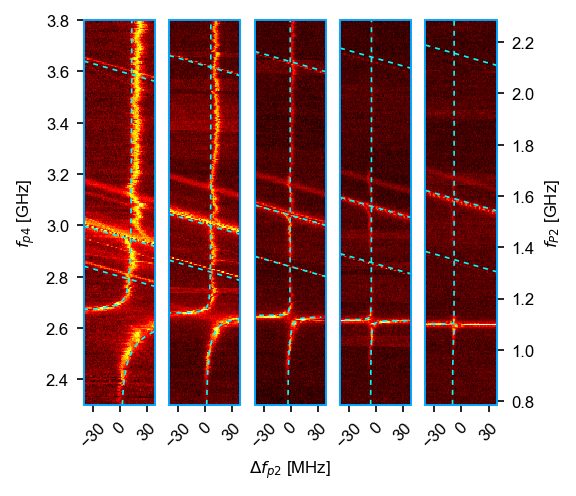

In [56]:
#%% path
import sys
import os

###Old average
script_dir = os.path.dirname() #<-- absolute dir the script is in
sys.path.append(script_dir)
save_path = os.path.join(script_dir, 'Figures')

#%% imports
import numpy as np
import matplotlib.pyplot as plt

#%% path

save_path = os.path.join(script_dir, 'Figures')
fig_size_single = 3.37
fig_size_double = 6.69

plt.rcParams['legend.frameon']= False
#plt.rcParams['legend.fontsize']= 'small'
plt.rcParams['legend.scatterpoints']= 1
plt.rcParams['axes.labelpad'] = 4 #-2

#%% load data

detuning_list = [(-11,11), (-10,10), (-9,9), (-8,8), (-7,7)]
start_time_dict = {(-11,11):'2022-07-11\\12-03-11',
                   (-10,10):'2022-07-11\\13-12-41',
                   (-9,9):'2022-07-11\\18-00-58',
                   (-8,8):'2022-07-11\\20-20-02',
                   (-7,7):'2022-07-12\\09-12-02',
                  }

datadir = os.path.join(script_dir, 'measurements')
datfiles_dict = {}
fnames_dict = {}

for detuning in detuning_list:
    start_time = start_time_dict[detuning]
    end_time = start_time #'2021-06-24\\18-03-01' #'2021-06-10\\18-32-47'
    datfiles_dict[detuning], fnames_dict[detuning] = get_data_from(start_time, end_time, num = 1, rootfolder=datadir, only_complete = False) 

#%% Calibrated Rabi frequencies
with open(os.path.join(script_dir, 'measurements\config_freq_rabi.txt'), "rb") as file:
    config_freq_rabi = pickle.load(file)

vP1 = -10
vP2 = 10
P2_pwr = -5
P4_pwr = 3

try:
    fq2p2 = config_freq_rabi['P2'][P2_pwr]['fq2'][(vP1,vP2)]
    fq2 = fq2p2
    fq1p4 = config_freq_rabi['P4'][P4_pwr]['fq1'][(vP1,vP2)]
    fq1 = fq1p4
except:
    print('Could not find calibrated data in database')
    fq1 = 1.51e9
    fq2 = 2.66e9

# mixing_regime = 'difference'
fq = fq1/1e9
#%% Plotting
fig, axs = plt.subplots(1, 5, figsize=(0.95*fig_size_single,0.95*3), sharex=True)
n = 0

VP1=1000*linspace(7,11,5)
VP2=-VP1
Ep2=EP2(1.141)
ratio_avg=t_avg**2/U
#aU=0.03583*10**(-3) #1/ueV
def ki3(VP1,ratio):
    return 2*Ep2*2*VP1*ratio*aU**2/(1*(1-aU**2*(2*VP1)**2)**2)
chi3_avg=ki3(VP1,ratio_avg)*1000/4.13566553853809*10**6 #Hz


def chi3_avg_eps(VP1):
    chi3=2*Ep2*2*VP1*t_avg**2*aU**2/(U*(1-aU**2*(2*VP1)**2)**2)
    chi3=chi3*241799.050402293*10**(-6)*10**(9)
    return chi3
chi3=chi3_avg_eps(11000)

y0s=[y0_11,y0_10,y0_9,y0_8,y0_7]
x0s=[x0_11,x0_10,x0_9,x0_8,x0_7]
chi3s=[chi3_11,chi3_10,chi3_9,chi3_8,chi3_7]
As=[A_11,A_10,A_9,A_8,A_7]

fq1s=[get_fq1(-11)*10**9,get_fq1(-10)*10**9,get_fq1(-9)*10**9,get_fq1(-8)*10**9,get_fq1(-7)*10**9]
BB=[5.0*10**(-9),5.0*10**(-9),5.0*10**(-9),5.0*10**(-9),5.0*10**(-9)]
fcs=[1.05*10**9,1.05*10**9,1.05*10**9,1.05*10**9,1.05*10**9]
y1ds=[2.667*10**9,2.656*10**9,2.648*10**9,2.6313*10**9,2.6143*10**9]
y1us=[3.8*10**9,3.8*10**9,3.8*10**9,3.8*10**9,3.8*10**9]
y2ds=[2.3*10**9,2.3*10**9,2.3*10**9,2.3*10**9,2.3*10**9]
y2us=[2.63*10**9,2.64*10**9,2.642*10**9,2.629*10**9,2.6122*10**9]

def plotting(x,ax,VP1):          #this function plots resonance lines 
    y1=2*get_fq1(VP1)*10**9-x
    y2=get_fq1(VP1)*10**9+get_fq2(VP1)*10**9/2-x
    y3=get_fq1(VP1)*10**9+get_fq2(VP1)*10**9/2+get_fq1b(VP1)*10**9/2-x
    ax.plot(x*10**(-6),y1*10**(-9),color='cyan',linewidth=0.8,linestyle=(0, (3,3)))
    ax.plot(x*10**(-6),y2*10**(-9),color='cyan',linewidth=0.8,linestyle=(0, (3,3)))
    ax.plot(x*10**(-6),y3*10**(-9),color='cyan',linewidth=0.8,linestyle=(0, (3,3)))
    
b=BB[0]
def x_1(y_u,y0,x0,A,chi3,fq1,fc):
    return (x0*(y_u-y0)+pow(10,0*(y_u-fq1-fc))*(A*(x0+y_u-y0+A*pow(10,0*(y_u-fq1-fc)))-chi3**2))/(y_u-y0+A*10**(0*(y_u-fq1-fc)))

def x_2(y_d,y0,x0,A,chi3,fq1,fc):
    return (x0*(y_d-y0)+pow(10,b*(y_d-fq1-fc))*(A*(x0+y_d-y0+A*pow(10,b*(y_d-fq1-fc)))-chi3**2))/(y_d-y0+A*10**(b*(y_d-fq1-fc)))


for detuning in detuning_list:
    datfile = datfiles_dict[detuning][0]
    
    delta = datfile.delta_set.ndarray[0,:]
    mixing = datfile.mixing_set.ndarray
    fp2 = mixing
    fp4 = abs(fp2 - fq)
    
    axs[n].pcolor(delta/1e6, fp2/1e9, datfile.su0, shading='auto', cmap='hot', zorder=0)
    #print(min(delta/1e6))
    #print(max(delta/1e6))
    axs[n].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    axs[n].tick_params('x', labelrotation=45) 
    axs[n].set_xticks([-30,0,+30])
    # axs[n].set_title(detuning, fontsize=8)
    for spine in axs[n].spines.values():
        spine.set_edgecolor('blue')
    
    xi=linspace(-40*10**6,39*10**6,5000)
    plotting(xi,axs[n],-11.0+n)
    y1=linspace(y1ds[n],y1us[n],5000)
    y2=linspace(y2ds[n],y2us[n],5000)
    axs[n].plot(x_1(y1,y0s[n],x0s[n],As[n],chi3s[n],fq1s[n],fcs[n])/1e6,y1/1e9,color='cyan',linewidth=0.8,linestyle=(0, (3,3)))
    axs[n].plot(x_2(y2,y0s[n],x0s[n],As[n],chi3s[n],fq1s[n],fcs[n])/1e6,y2/1e9,color='cyan',linewidth=0.8,linestyle=(0, (3,3)))
    axs[n].set_xlim(-40,39)
    axs[n].set_ylim(2.3,3.8)
    
    if n > 0:
         axs[n].set_yticks([])
    
    ax2 = axs[n].twinx()
    ax2.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    fp2_max, fp2_min = axs[n].get_ylim()
    ax2.set_ylim(fp2_max - fq, fp2_min - fq)
    if n < len(detuning_list)-1:
        ax2.set_yticklabels([])
        ax2.set_yticks([])
    for spine in ax2.spines.values():
        spine.set_edgecolor('deepskyblue')

    n = n + 1
    
axs[0].set_ylabel(r'$f_{p4}$ [GHz]')
axs[2].set_xlabel(r'$\Delta f_{p2}$ [MHz]')
ax2.set_ylabel('$f_{P2}$ [GHz]')

plt.subplots_adjust(left=0.07,
                    bottom=0.05,
                    right=0.93,
                    top=0.95,
                    hspace=0)

plt.show()

fig.savefig('Figure4_overlayed.pdf',format='pdf', dpi=300,bbox_inches="tight")
fig.savefig('Figure4_overlayed.png',format='png',dpi=300,bbox_inches="tight")
fig.savefig('Figure4_overlayed.svg',format='svg',bbox_inches="tight")